In [1]:
import pandas as pd
import numpy as np
import zipfile

def apk(actual, predicated, k=7, default=0.0):
    # MAP@7 이므로 최대 7개 까지 사용
    if len(predicated) > k:
        predicated = predicated[:k]
    
    score = 0.0
    num_hits = 0.0
    
    for i, p in enumerate(predicated):
        if p in actual and p not in predicated[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    
    if not actual:
        return default
    
    return score / min(len(actual), k)
    
def mapk(actual, predicated, k=7, default=0.0):
    return np.mean([apk(a, p, k, default) for a, p in zip(actual, predicated)])


trn = pd.read_csv('../input/s-product-recomendation/train_ver2.csv');

trn.shape
# 13.647.309 명의 고객이 있고, 각 고객당 48개의 컬럼이 존재한다.

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(13647309, 48)

In [2]:
trn.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [3]:
for col in trn.columns:
    print('{}\n'.format(trn[col].head()))

0    2015-01-28
1    2015-01-28
2    2015-01-28
3    2015-01-28
4    2015-01-28
Name: fecha_dato, dtype: object

0    1375586
1    1050611
2    1050612
3    1050613
4    1050614
Name: ncodpers, dtype: int64

0    N
1    N
2    N
3    N
4    N
Name: ind_empleado, dtype: object

0    ES
1    ES
2    ES
3    ES
4    ES
Name: pais_residencia, dtype: object

0    H
1    V
2    V
3    H
4    V
Name: sexo, dtype: object

0     35
1     23
2     23
3     22
4     23
Name: age, dtype: object

0    2015-01-12
1    2012-08-10
2    2012-08-10
3    2012-08-10
4    2012-08-10
Name: fecha_alta, dtype: object

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: ind_nuevo, dtype: float64

0          6
1         35
2         35
3         35
4         35
Name: antiguedad, dtype: object

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: indrel, dtype: float64

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: ult_fec_cli_1t, dtype: object

0    1
1    1
2    1
3    1
4    1
Name: indrel_1mes, dtype: obje

In [5]:
# pandas에서 자동으로 정보를 요약
trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
fecha_dato               object
ncodpers                 int64
ind_empleado             object
pais_residencia          object
sexo                     object
age                      object
fecha_alta               object
ind_nuevo                float64
antiguedad               object
indrel                   float64
ult_fec_cli_1t           object
indrel_1mes              object
tiprel_1mes              object
indresi                  object
indext                   object
conyuemp                 object
canal_entrada            object
indfall                  object
tipodom                  float64
cod_prov                 float64
nomprov                  object
ind_actividad_cliente    float64
renta                    float64
segmento                 object
ind_ahor_fin_ult1        int64
ind_aval_fin_ult1        int64
ind_cco_fin_ult1         int64
ind_cder_fin_ult1  

In [6]:
# 첫 24개의 고객 변수 중 ['int64', 'float64'] 의 데이터 타입을 갖는 수치형 변수 분석
num_cols = [col for col in trn.columns[:24] if trn[col].dtype in ['int64', 'float64']]
trn[num_cols].describe()

,ncodpers,ind_nuevo,indrel,tipodom,cod_prov,ind_actividad_cliente,renta
count,1.364731e+07,1.361958e+07,1.361958e+07,13619574.0,1.355372e+07,1.361958e+07,1.085293e+07
mean,8.349042e+05,5.956184e-02,1.178399e+00,1.0,2.657147e+01,4.578105e-01,1.342543e+05
std,4.315650e+05,2.366733e-01,4.177469e+00,0.0,1.278402e+01,4.982169e-01,2.306202e+05
min,1.588900e+04,0.000000e+00,1.000000e+00,1.0,1.000000e+00,0.000000e+00,1.202730e+03
25%,4.528130e+05,0.000000e+00,1.000000e+00,1.0,1.500000e+01,0.000000e+00,6.871098e+04
50%,9.318930e+05,0.000000e+00,1.000000e+00,1.0,2.800000e+01,0.000000e+00,1.018500e+05
75%,1.199286e+06,0.000000e+00,1.000000e+00,1.0,3.500000e+01,1.000000e+00,1.559560e+05
max,1.553689e+06,1.000000e+00,9.900000e+01,1.0,5.200000e+01,1.000000e+00,2.889440e+07


In [8]:
# 첫 24개의 고객 변수 중 ['object'] 의 데이터 타입을 갖는 범주형 변수 분석
cat_cols = [col for col in trn.columns[:24] if trn[col].dtype in ['O']]
trn[cat_cols].describe()

,fecha_dato,ind_empleado,pais_residencia,sexo,age,fecha_alta,antiguedad,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,nomprov,segmento
count,13647309,13619575,13619575,13619505,13647309,13619575,13647309,24793,13497528.0,13497528,13619575,13619575,1808,13461183,13619575,13553718,13457941
unique,17,5,118,2,235,6756,507,223,13.0,5,2,2,2,162,2,52,3
top,2016-05-28,N,ES,V,23,2014-07-28,0,2015-12-24,1.0,I,S,N,N,KHE,N,MADRID,02 - PARTICULARES
freq,931453,13610977,13553710,7424252,542682,57389,134335,763,7277607.0,7304875,13553711,12974839,1791,4055270,13584813,4409600,7960220


In [12]:
for col in cat_cols:
    uniq = np.unique(trn[col].astype(str))
    print('-' * 50)
    print('# col {}, n_uniq {}, uniq {}'.format(col, len(uniq), uniq))

--------------------------------------------------
# col fecha_dato, n_uniq 17, uniq ['2015-01-28' '2015-02-28' '2015-03-28' '2015-04-28' '2015-05-28'
 '2015-06-28' '2015-07-28' '2015-08-28' '2015-09-28' '2015-10-28'
 '2015-11-28' '2015-12-28' '2016-01-28' '2016-02-28' '2016-03-28'
 '2016-04-28' '2016-05-28']
--------------------------------------------------
# col ind_empleado, n_uniq 6, uniq ['A' 'B' 'F' 'N' 'S' 'nan']
--------------------------------------------------
# col pais_residencia, n_uniq 119, uniq ['AD' 'AE' 'AL' 'AO' 'AR' 'AT' 'AU' 'BA' 'BE' 'BG' 'BM' 'BO' 'BR' 'BY'
 'BZ' 'CA' 'CD' 'CF' 'CG' 'CH' 'CI' 'CL' 'CM' 'CN' 'CO' 'CR' 'CU' 'CZ'
 'DE' 'DJ' 'DK' 'DO' 'DZ' 'EC' 'EE' 'EG' 'ES' 'ET' 'FI' 'FR' 'GA' 'GB'
 'GE' 'GH' 'GI' 'GM' 'GN' 'GQ' 'GR' 'GT' 'GW' 'HK' 'HN' 'HR' 'HU' 'IE'
 'IL' 'IN' 'IS' 'IT' 'JM' 'JP' 'KE' 'KH' 'KR' 'KW' 'KZ' 'LB' 'LT' 'LU'
 'LV' 'LY' 'MA' 'MD' 'MK' 'ML' 'MM' 'MR' 'MT' 'MX' 'MZ' 'NG' 'NI' 'NL'
 'NO' 'NZ' 'OM' 'PA' 'PE' 'PH' 'PK' 'PL' 'PR' 'PT' 'PY' 'Q

--------------------------------------------------
# col indrel_1mes, n_uniq 10, uniq ['1' '1.0' '2' '2.0' '3' '3.0' '4' '4.0' 'P' 'nan']
--------------------------------------------------
# col tiprel_1mes, n_uniq 6, uniq ['A' 'I' 'N' 'P' 'R' 'nan']
--------------------------------------------------
# col indresi, n_uniq 3, uniq ['N' 'S' 'nan']
--------------------------------------------------
# col indext, n_uniq 3, uniq ['N' 'S' 'nan']
--------------------------------------------------
# col conyuemp, n_uniq 3, uniq ['N' 'S' 'nan']
--------------------------------------------------
# col canal_entrada, n_uniq 163, uniq ['004' '007' '013' '025' 'K00' 'KAA' 'KAB' 'KAC' 'KAD' 'KAE' 'KAF' 'KAG'
 'KAH' 'KAI' 'KAJ' 'KAK' 'KAL' 'KAM' 'KAN' 'KAO' 'KAP' 'KAQ' 'KAR' 'KAS'
 'KAT' 'KAU' 'KAV' 'KAW' 'KAY' 'KAZ' 'KBB' 'KBD' 'KBE' 'KBF' 'KBG' 'KBH'
 'KBJ' 'KBL' 'KBM' 'KBN' 'KBO' 'KBP' 'KBQ' 'KBR' 'KBS' 'KBU' 'KBV' 'KBW'
 'KBX' 'KBY' 'KBZ' 'KCA' 'KCB' 'KCC' 'KCD' 'KCE' 'KCF' 'KCG' 'KCH' 'KCI'
 'KC

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

--------------------------------------------------
col :  fecha_dato


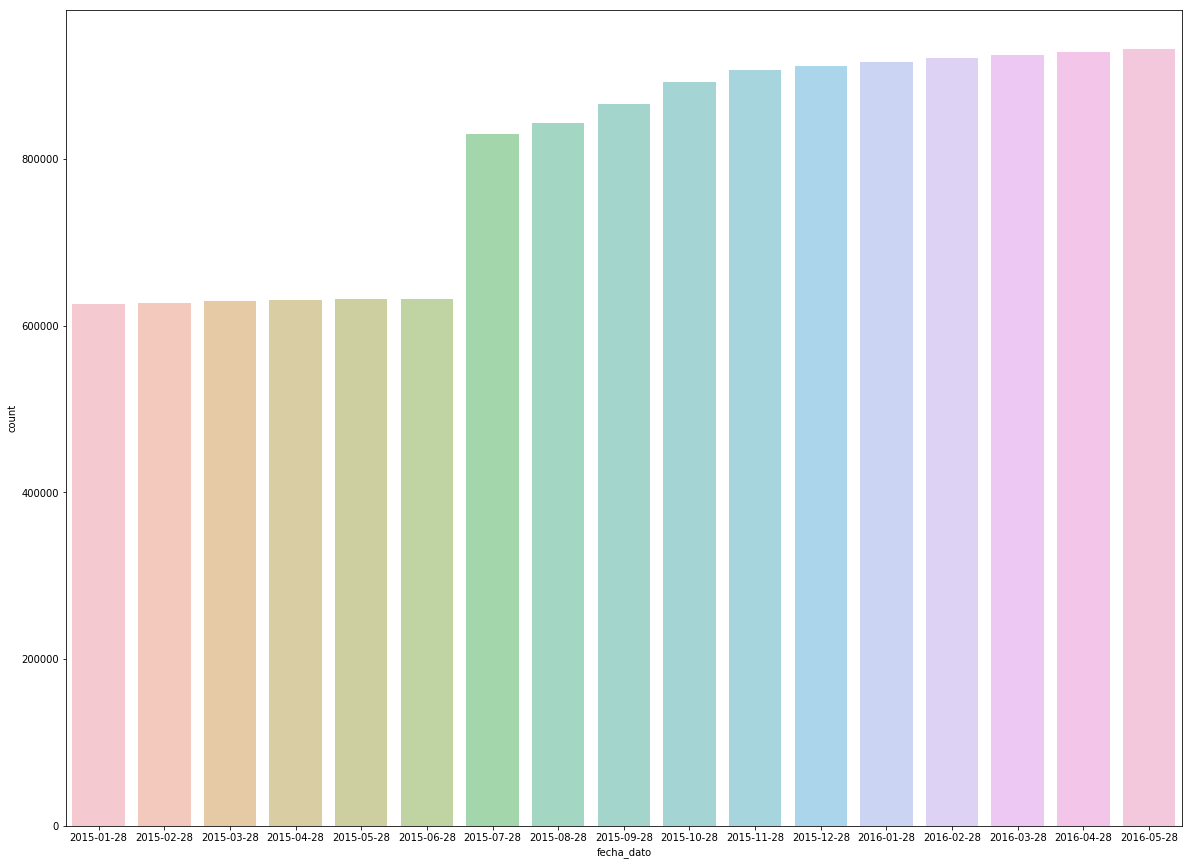

--------------------------------------------------
col :  ind_empleado


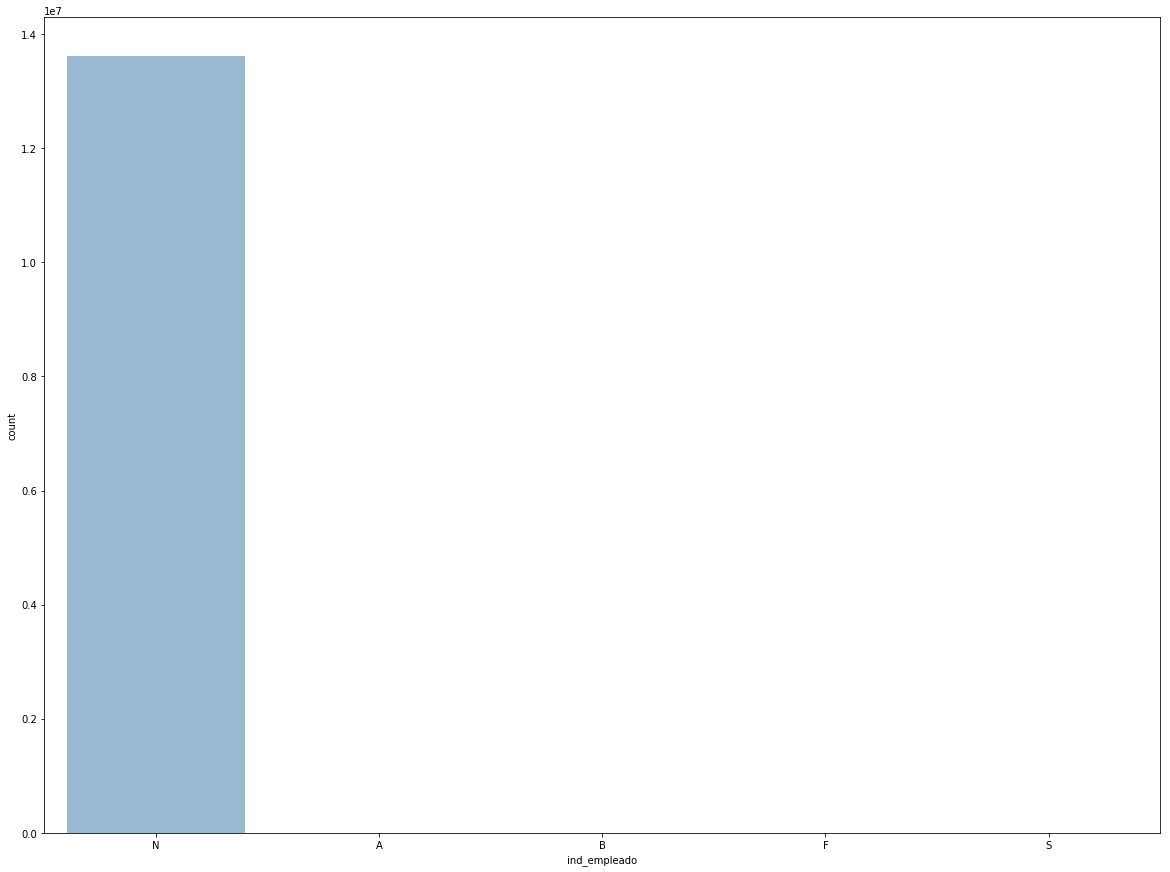

--------------------------------------------------
col :  pais_residencia


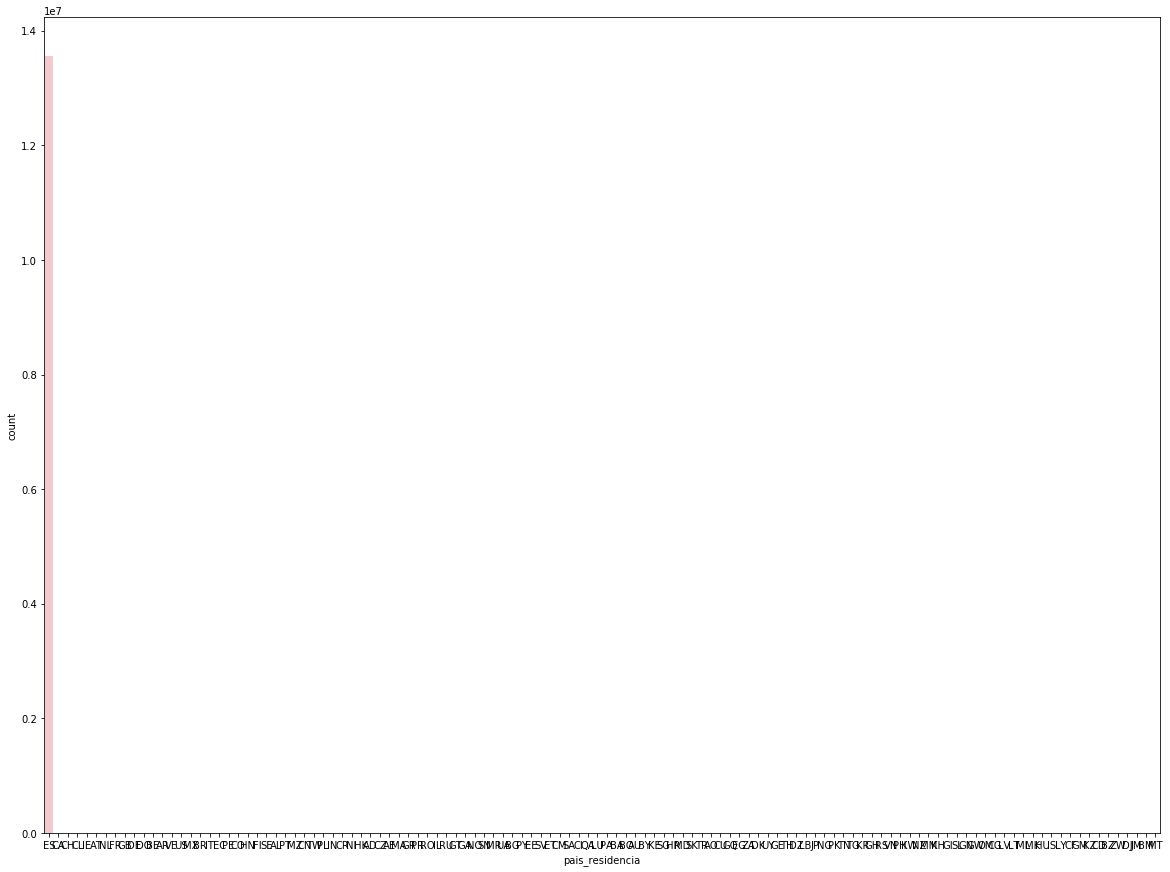

--------------------------------------------------
col :  sexo


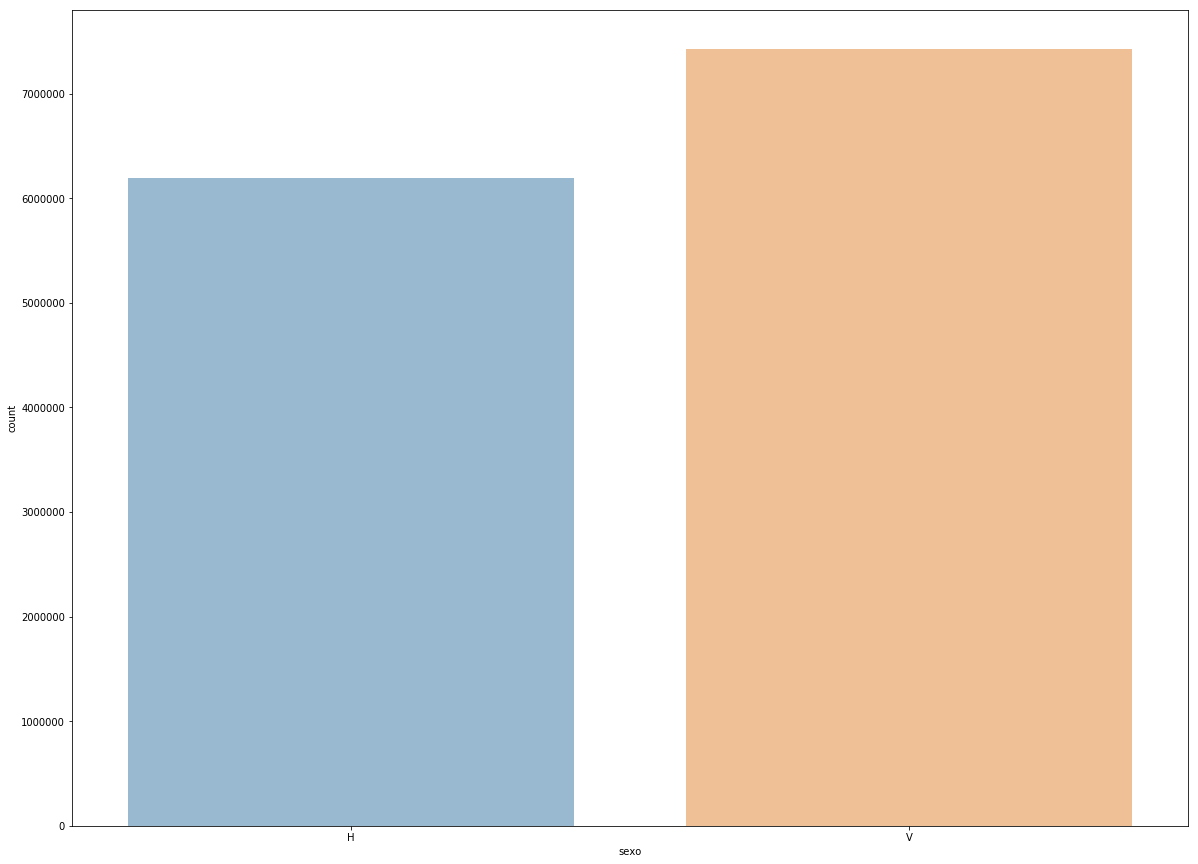

--------------------------------------------------
col :  age


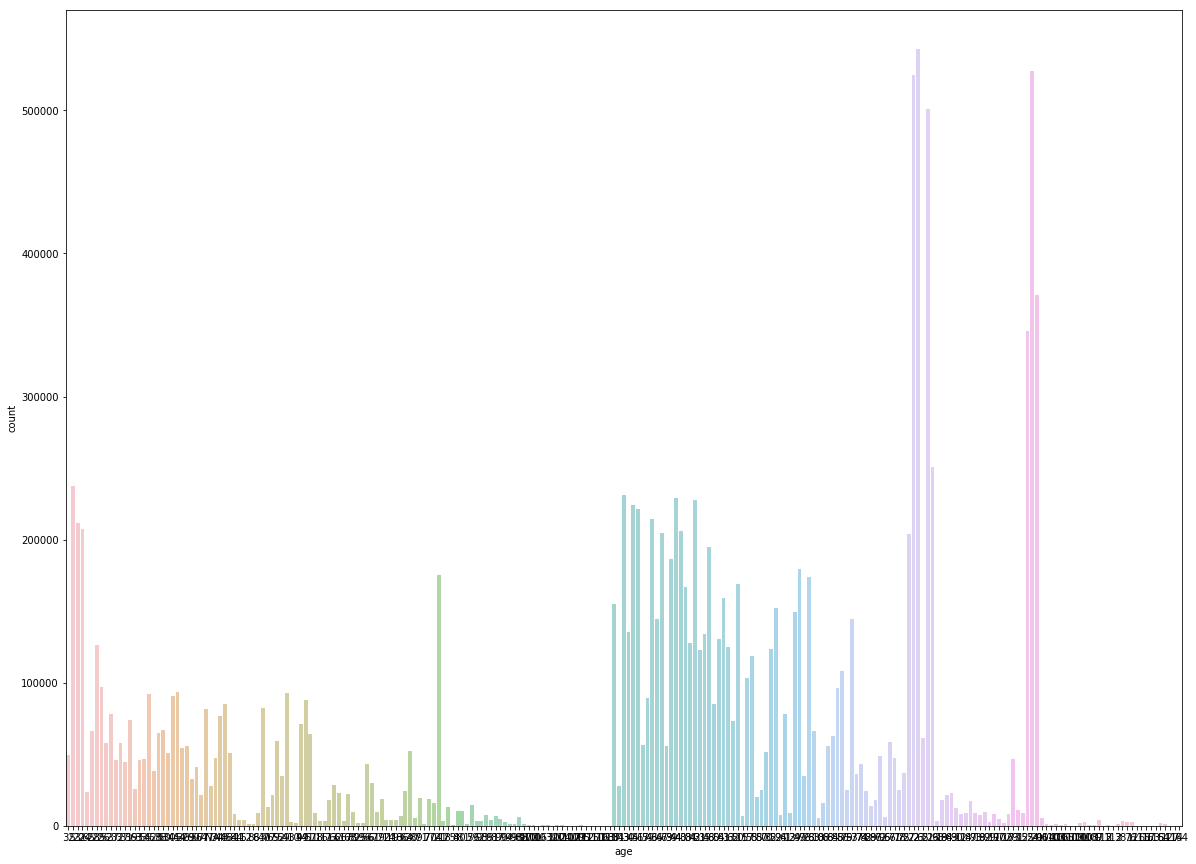

--------------------------------------------------
col :  fecha_alta


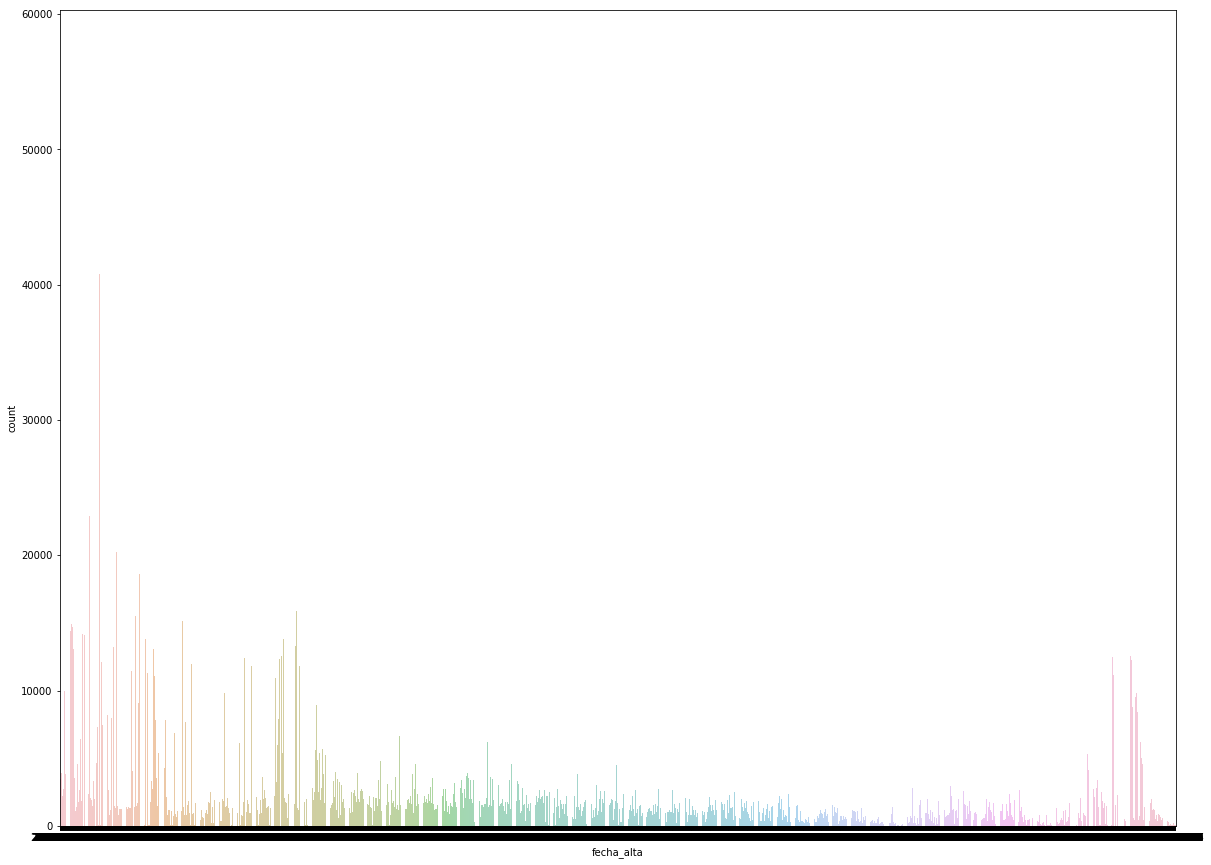

--------------------------------------------------
col :  ind_nuevo


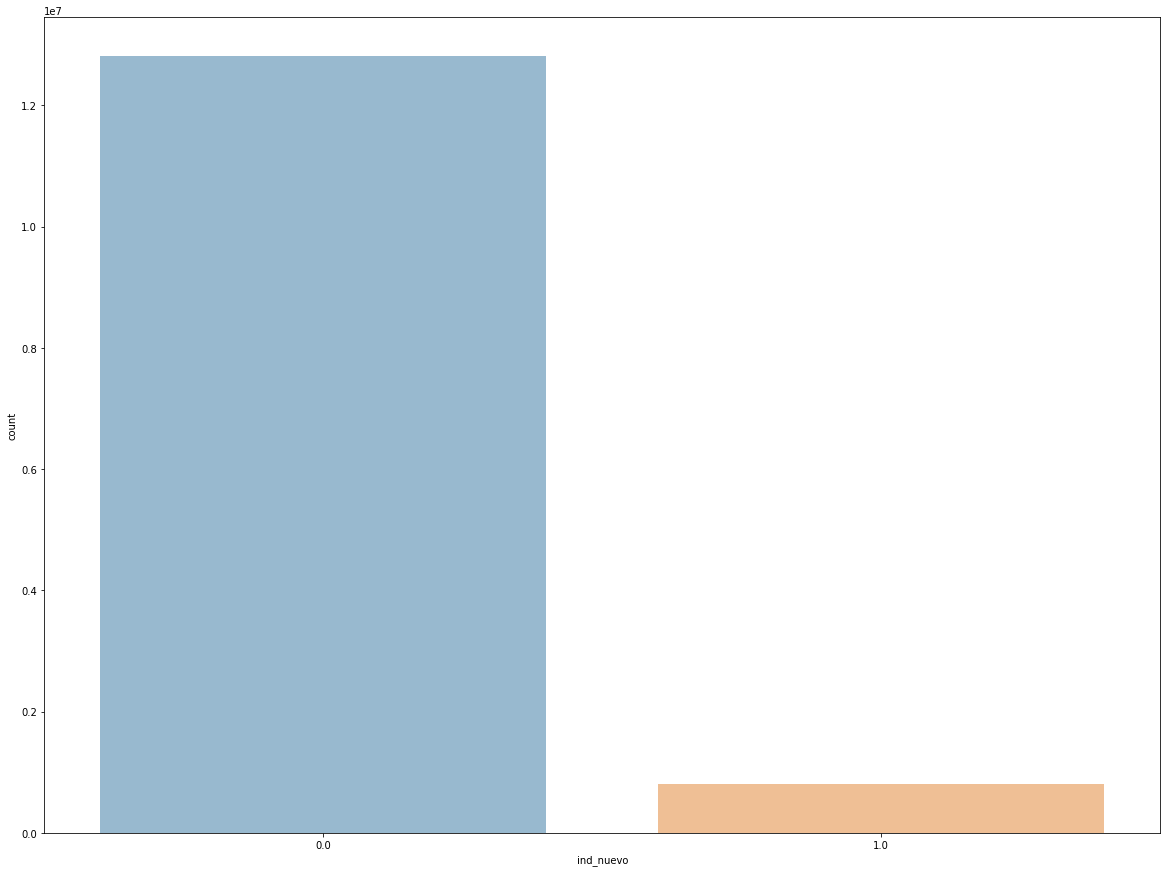

--------------------------------------------------
col :  antiguedad


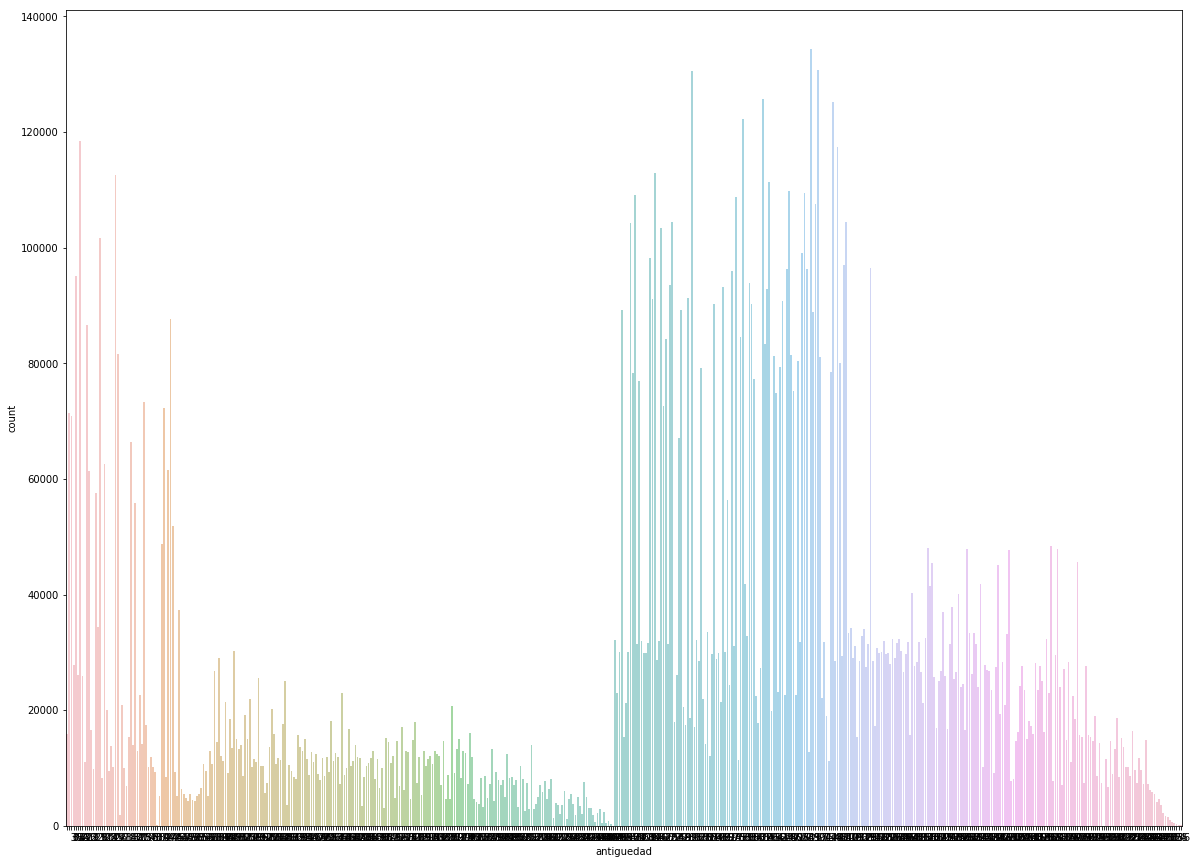

--------------------------------------------------
col :  indrel


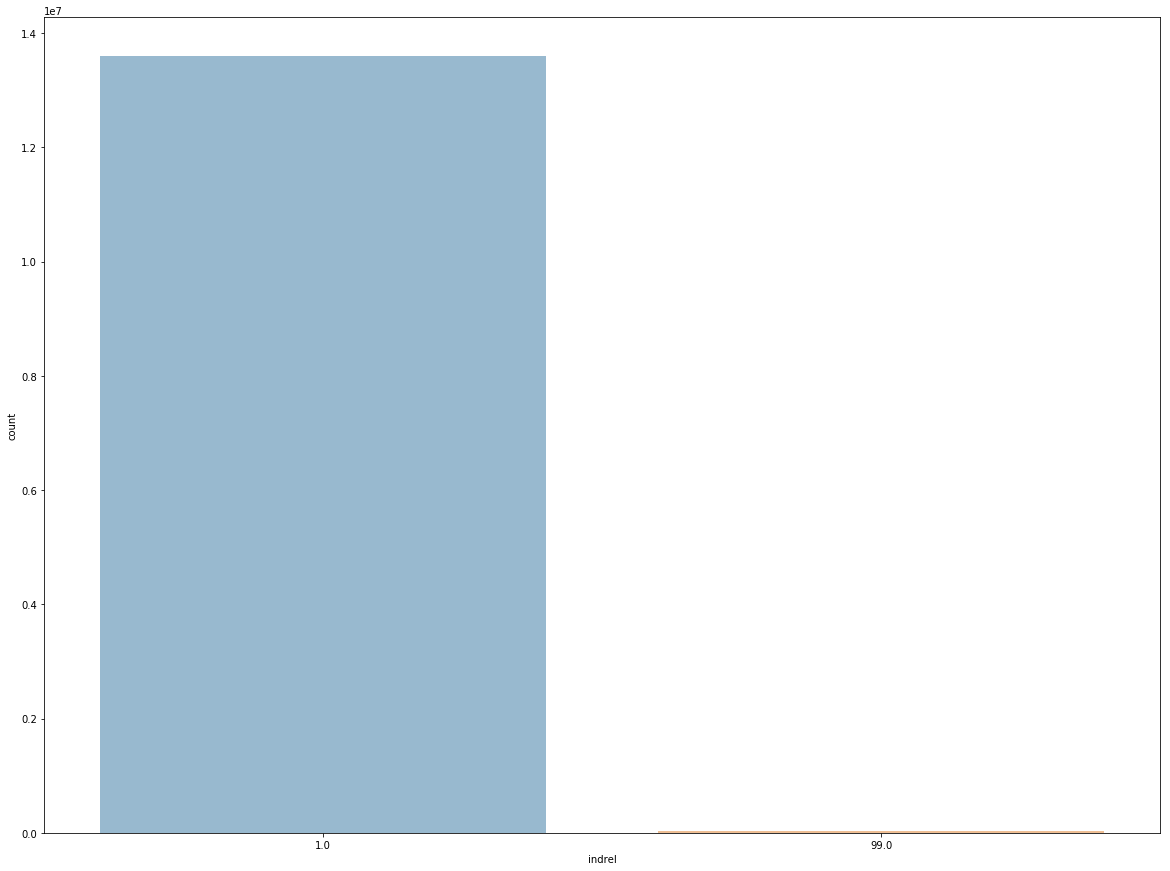

--------------------------------------------------
col :  ult_fec_cli_1t


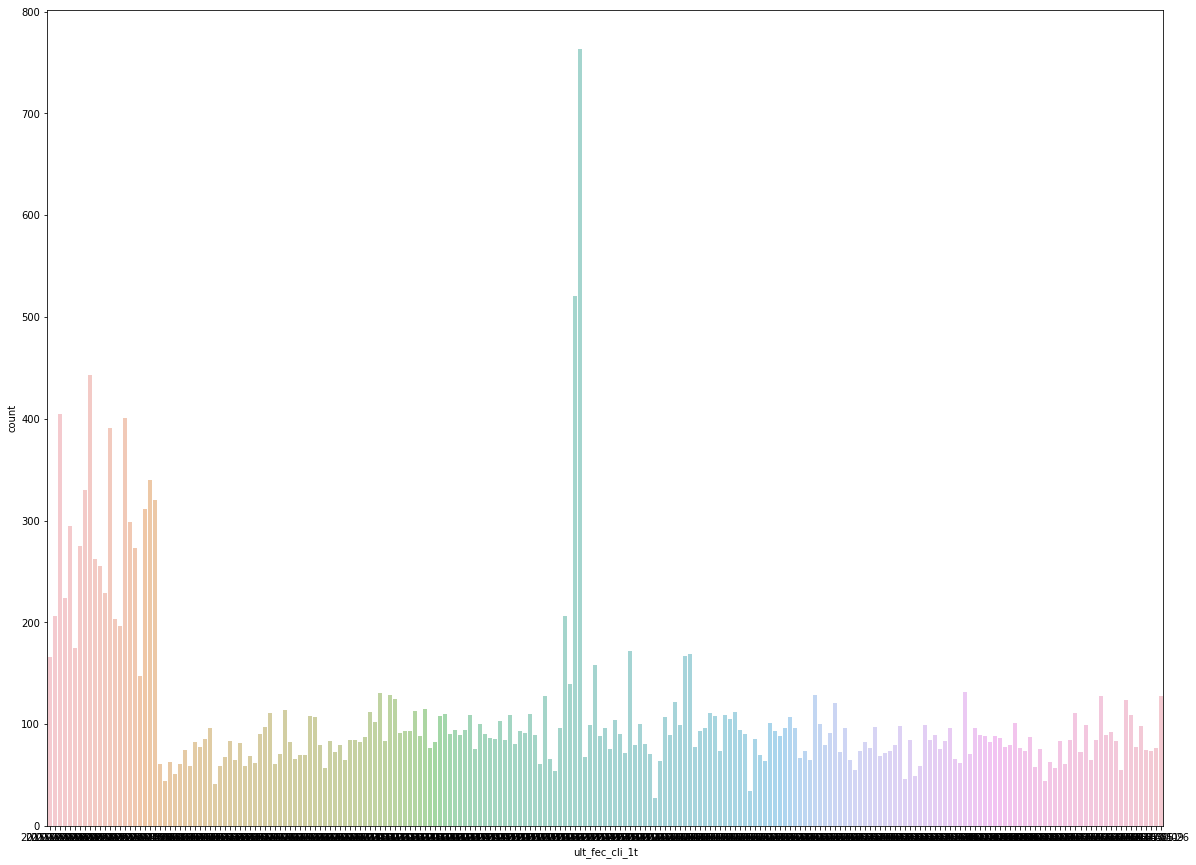

--------------------------------------------------
col :  indrel_1mes


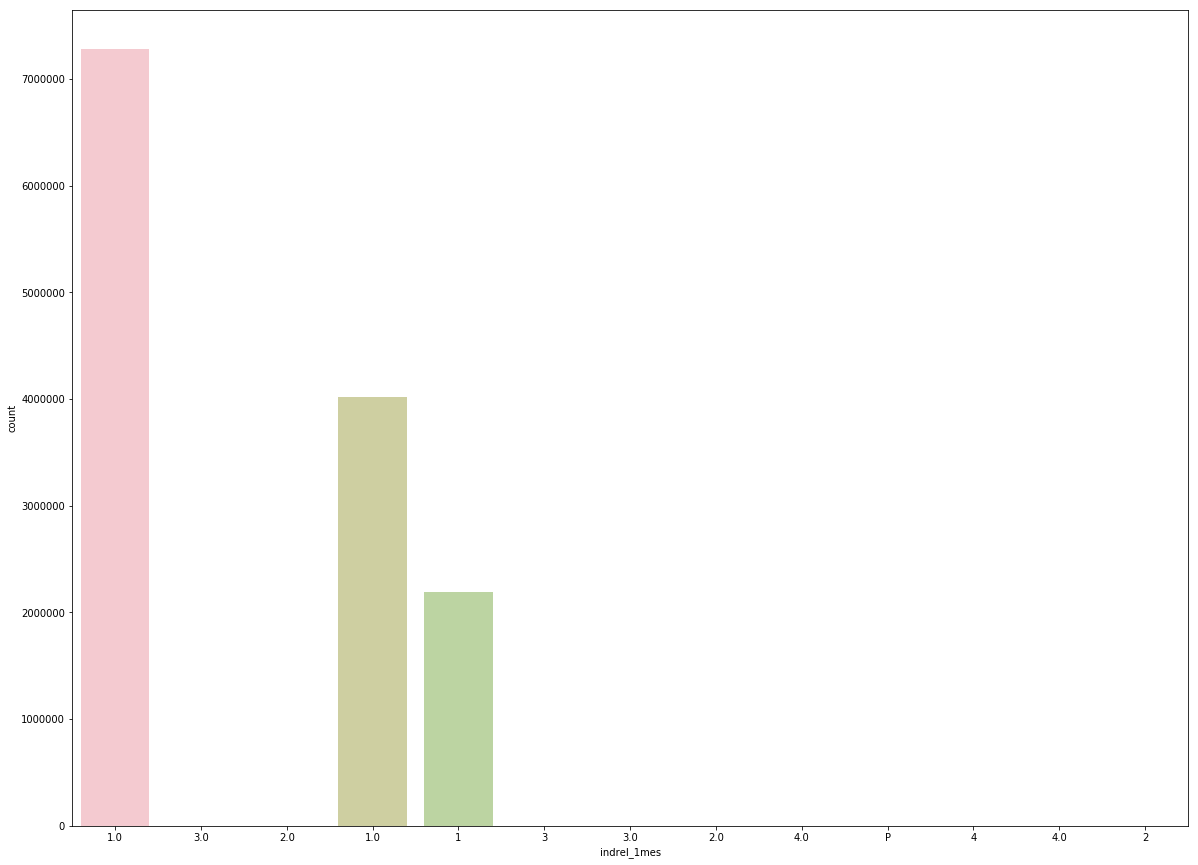

--------------------------------------------------
col :  tiprel_1mes


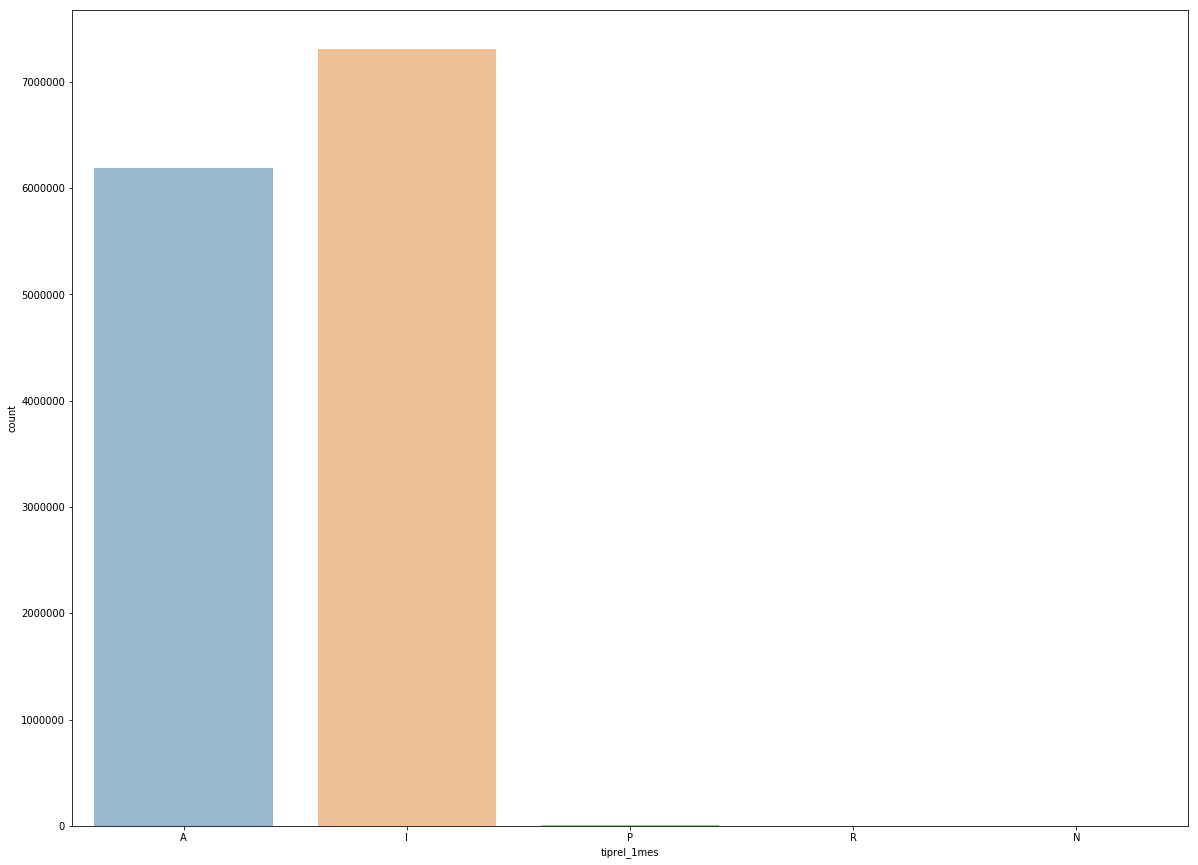

--------------------------------------------------
col :  indresi


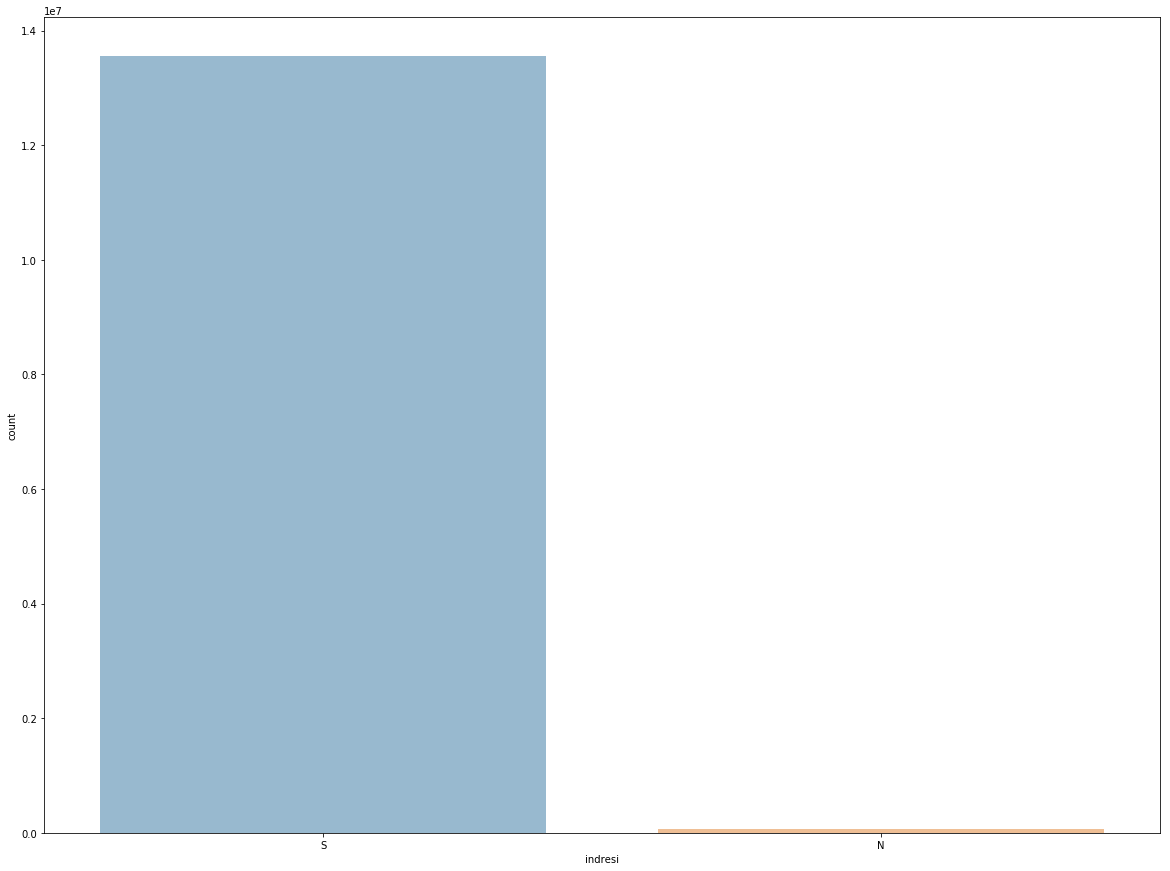

--------------------------------------------------
col :  indext


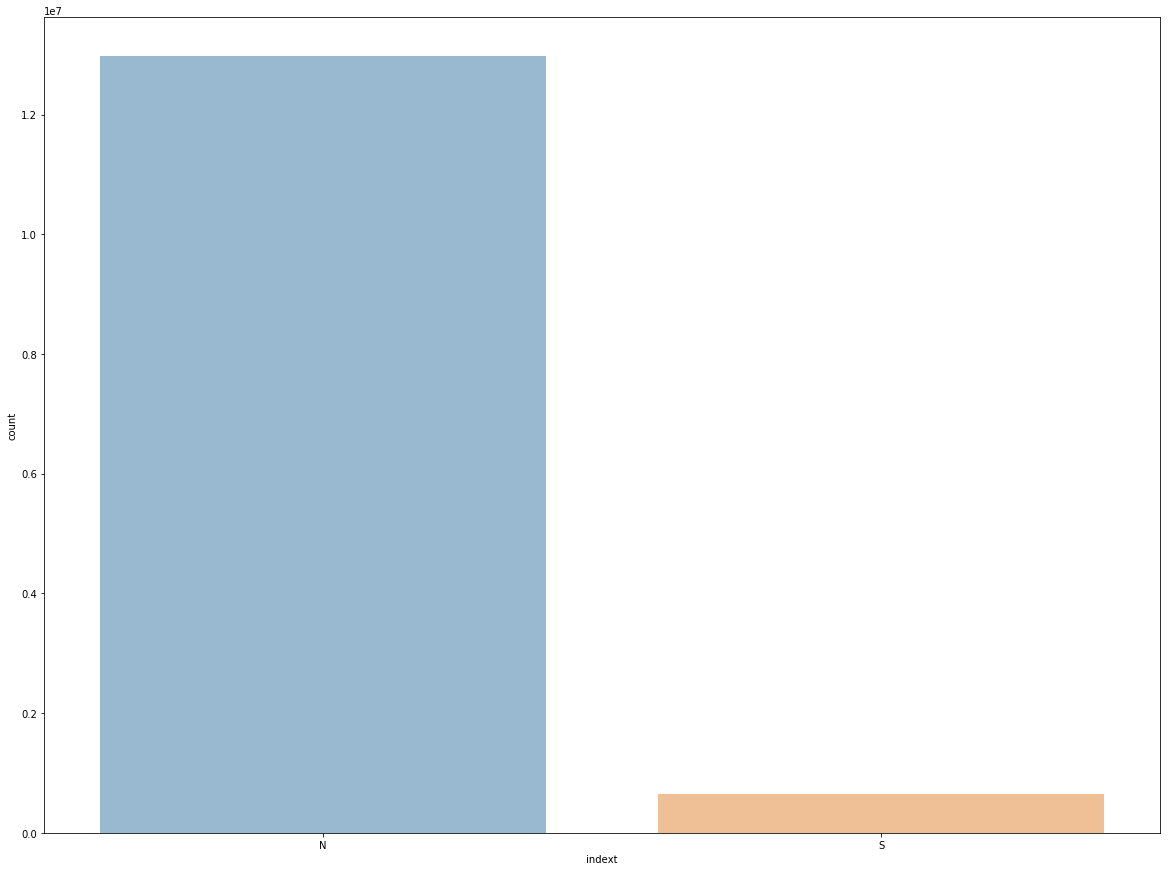

--------------------------------------------------
col :  conyuemp


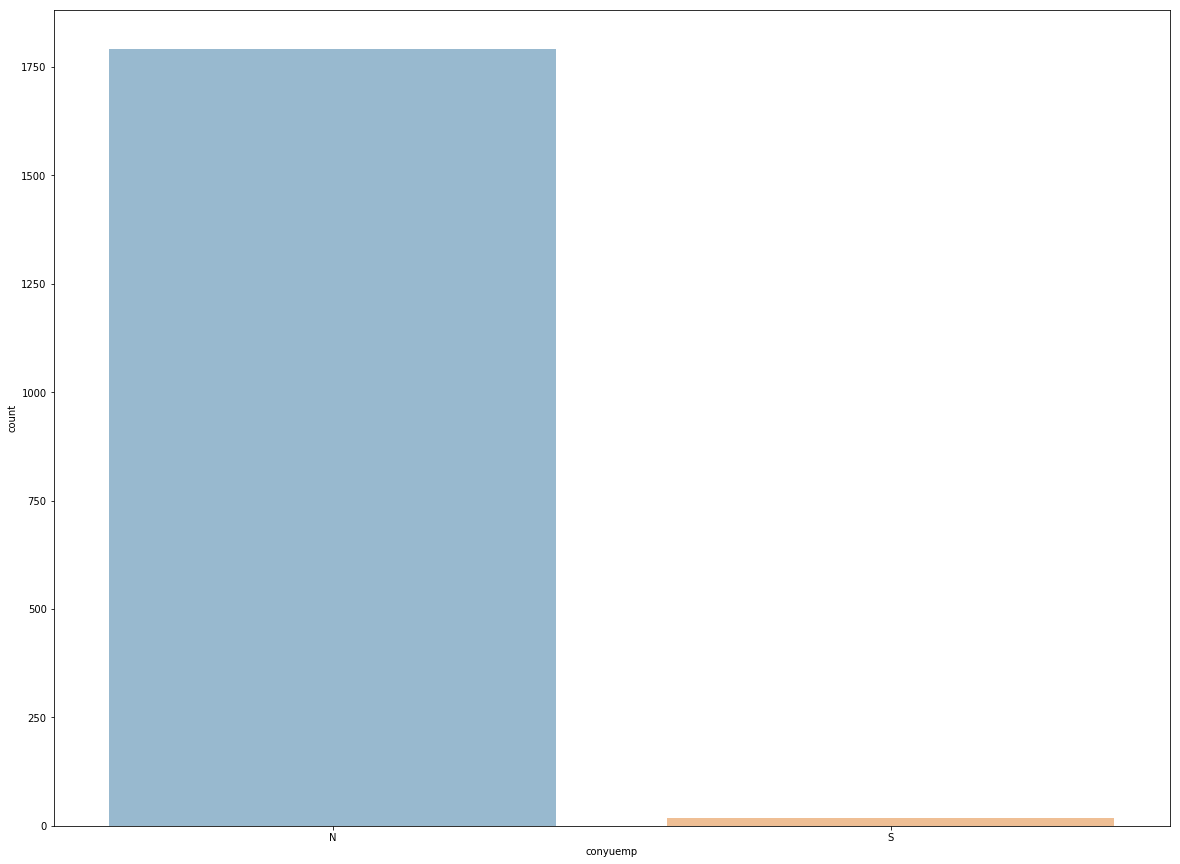

--------------------------------------------------
col :  canal_entrada


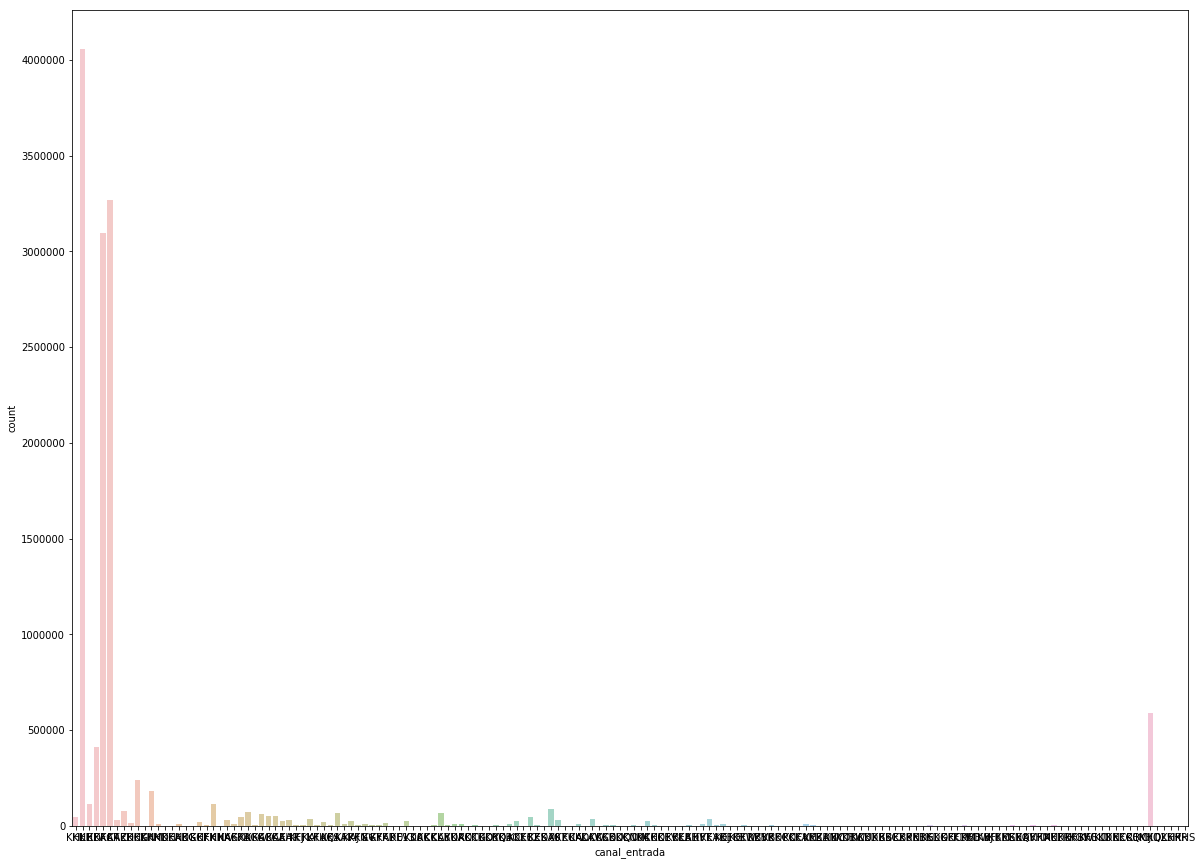

--------------------------------------------------
col :  indfall


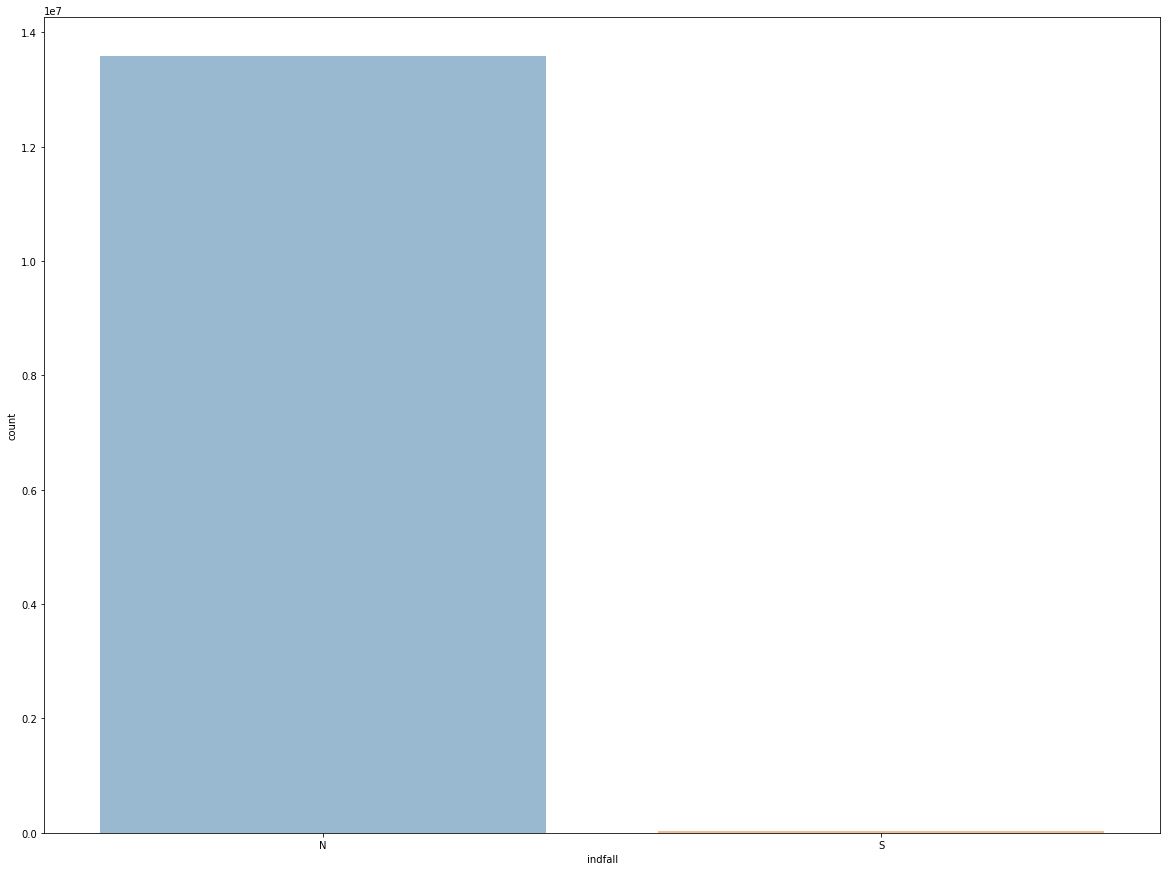

--------------------------------------------------
col :  tipodom


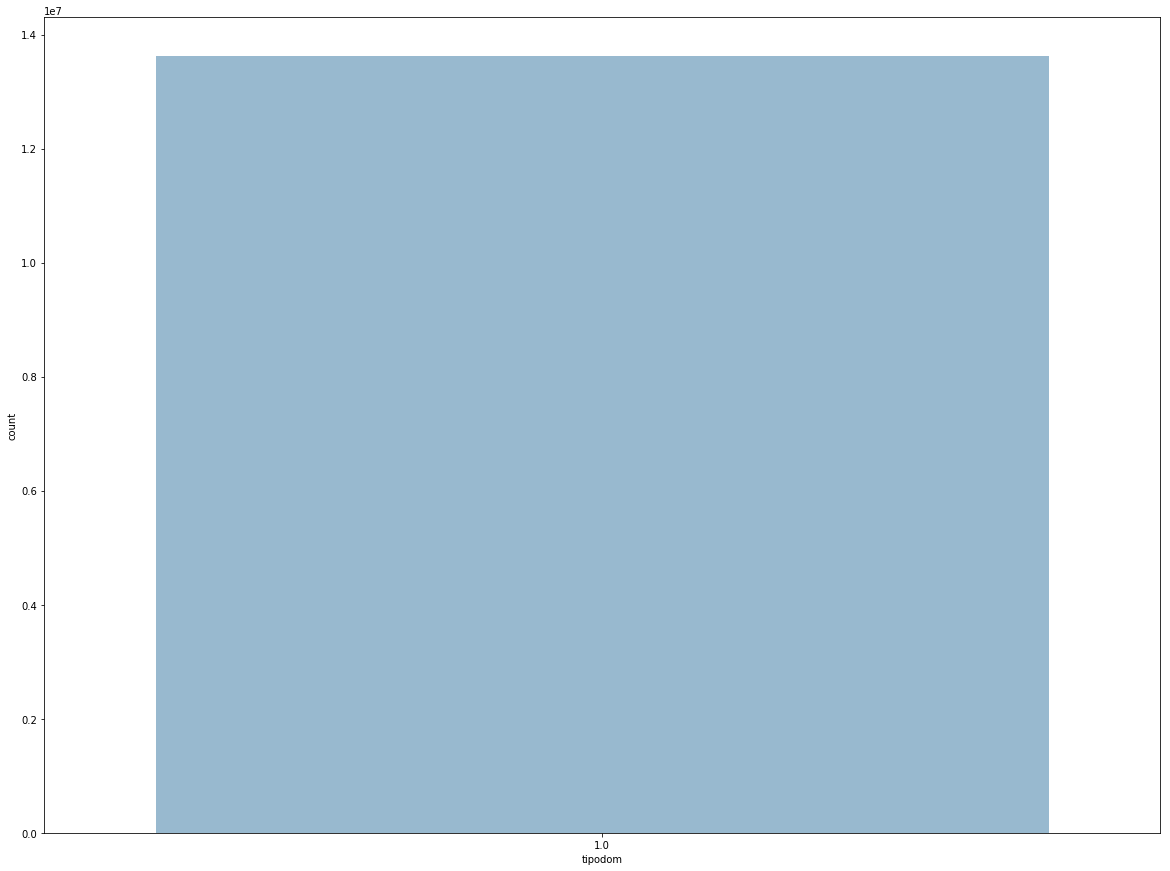

--------------------------------------------------
col :  cod_prov


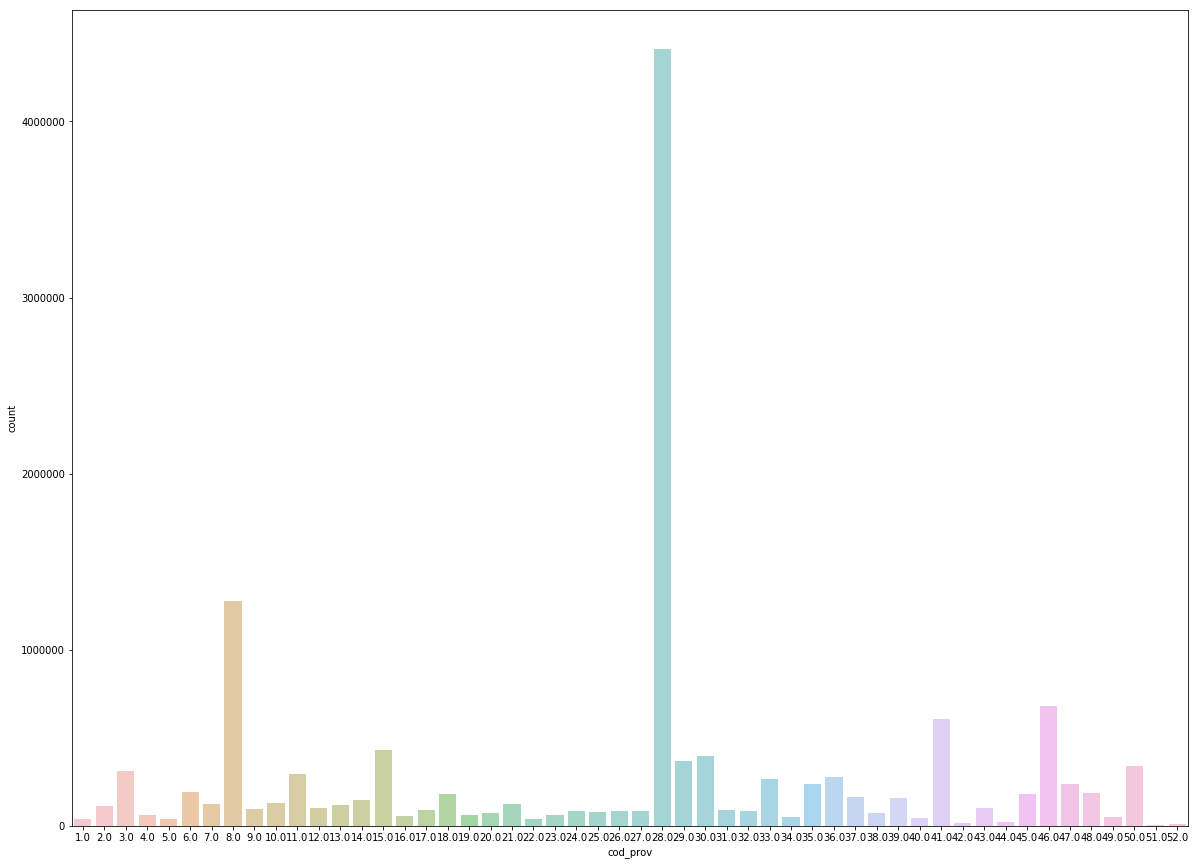

--------------------------------------------------
col :  nomprov


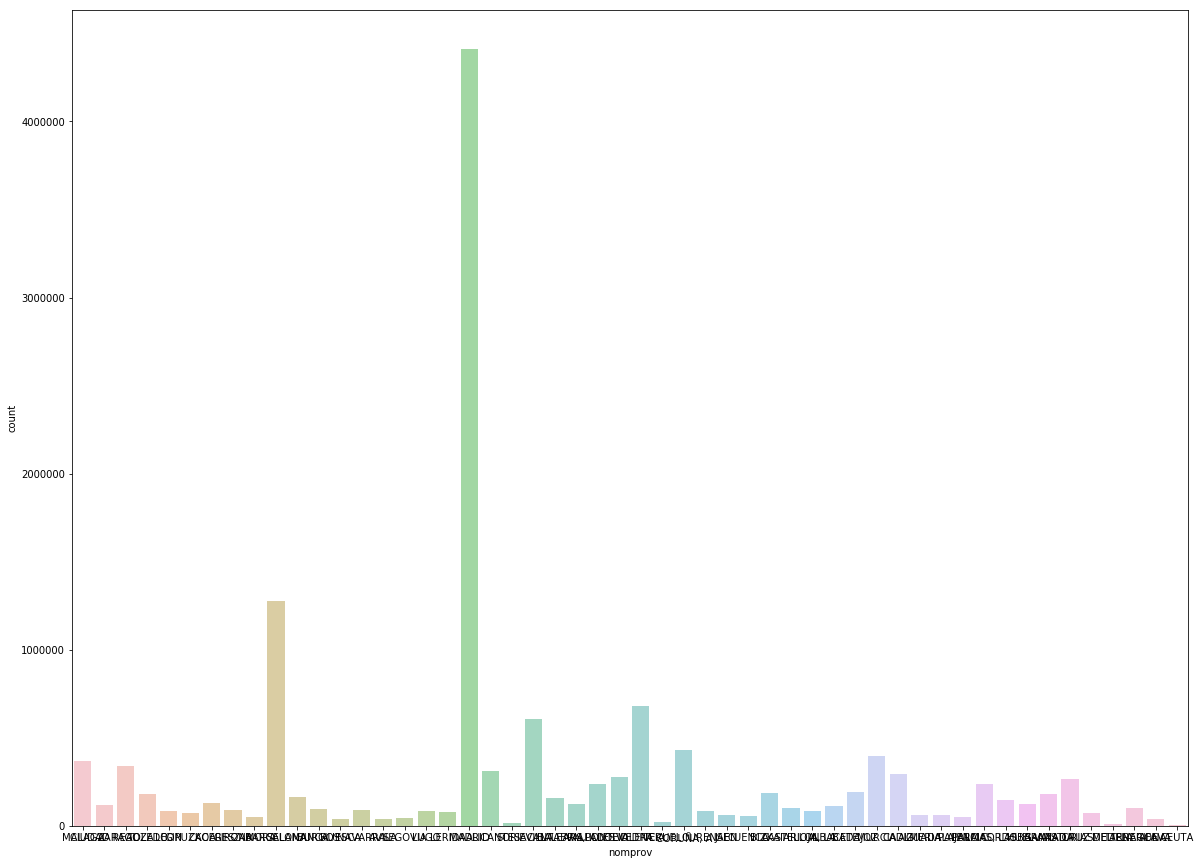

--------------------------------------------------
col :  ind_actividad_cliente


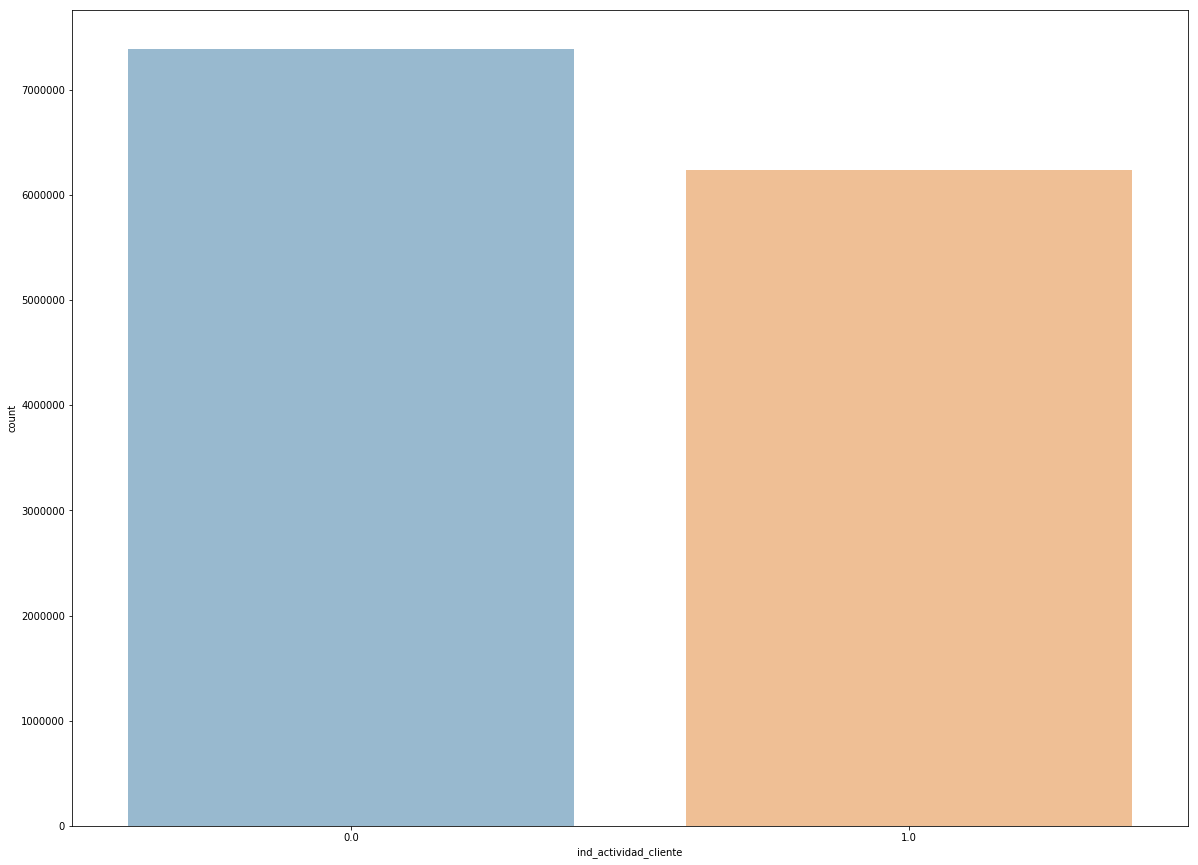

--------------------------------------------------
col :  segmento


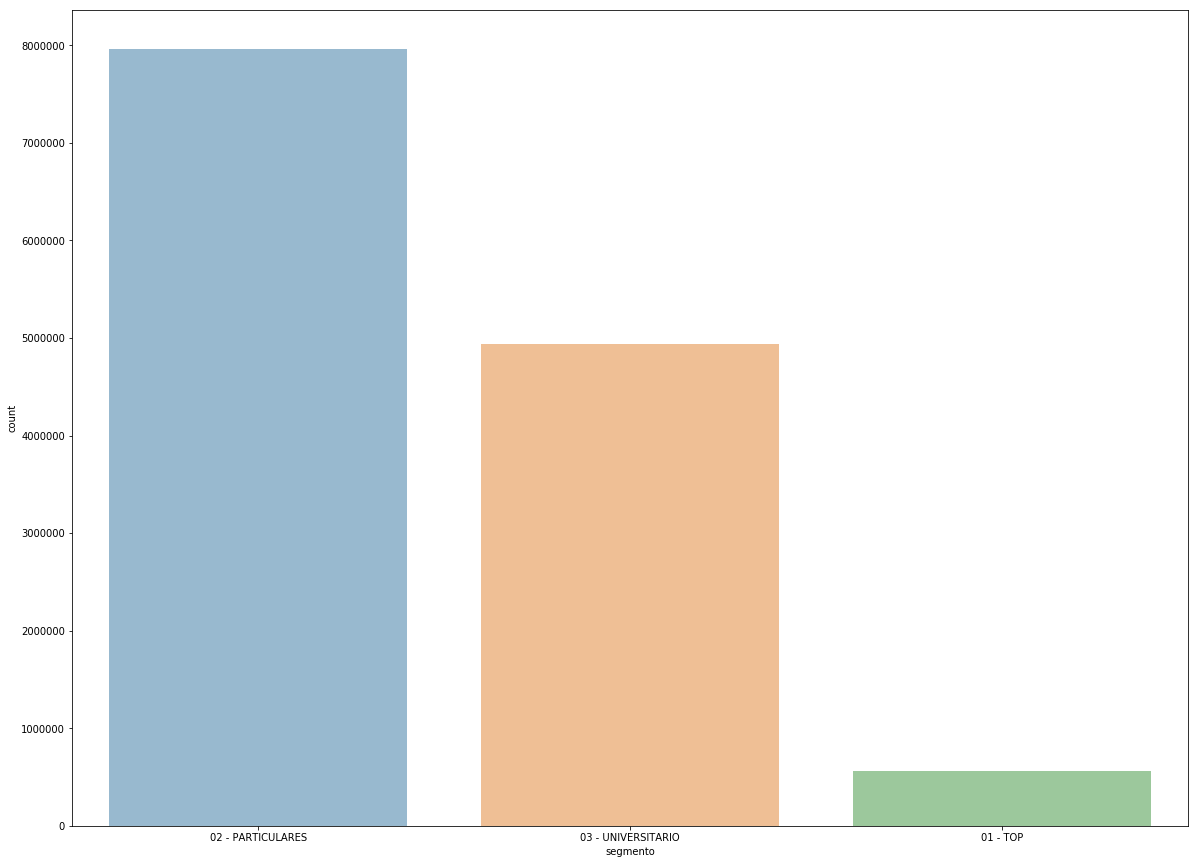

--------------------------------------------------
col :  ind_ahor_fin_ult1


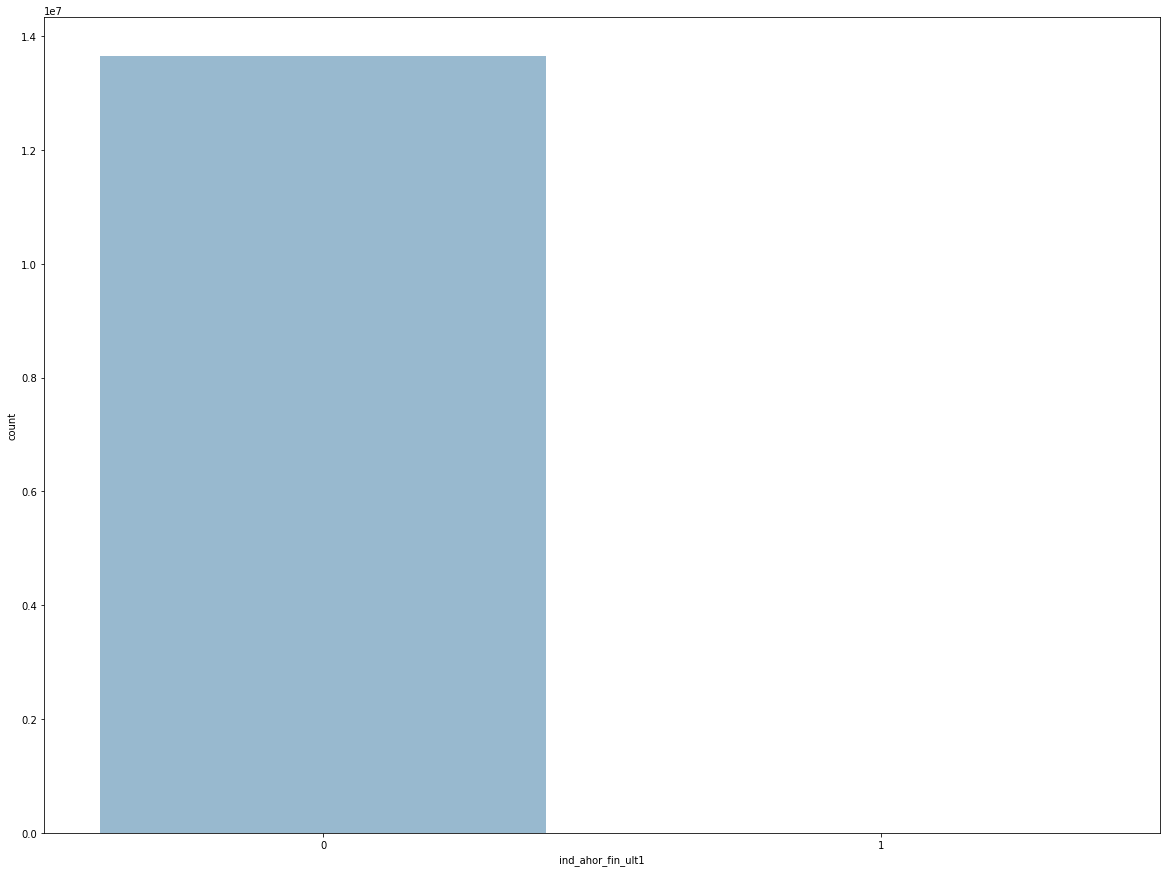

--------------------------------------------------
col :  ind_aval_fin_ult1


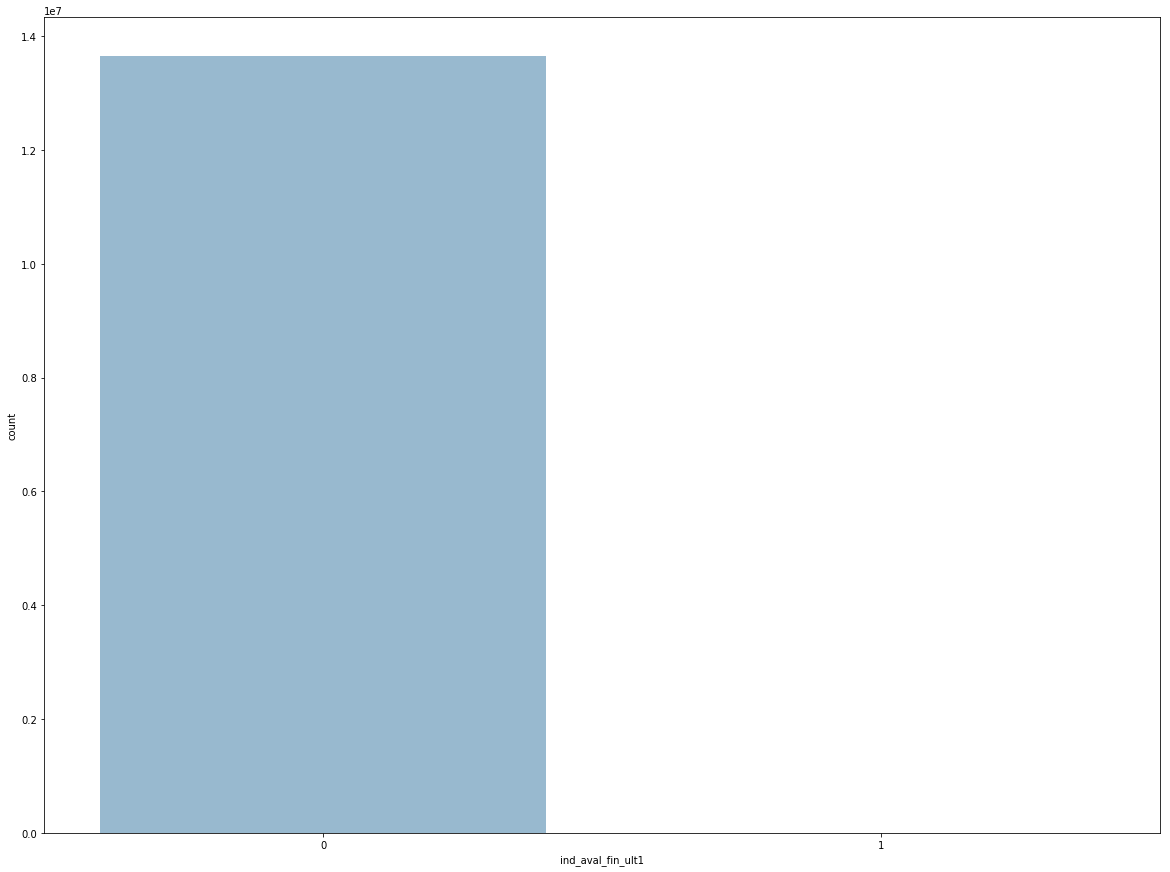

--------------------------------------------------
col :  ind_cco_fin_ult1


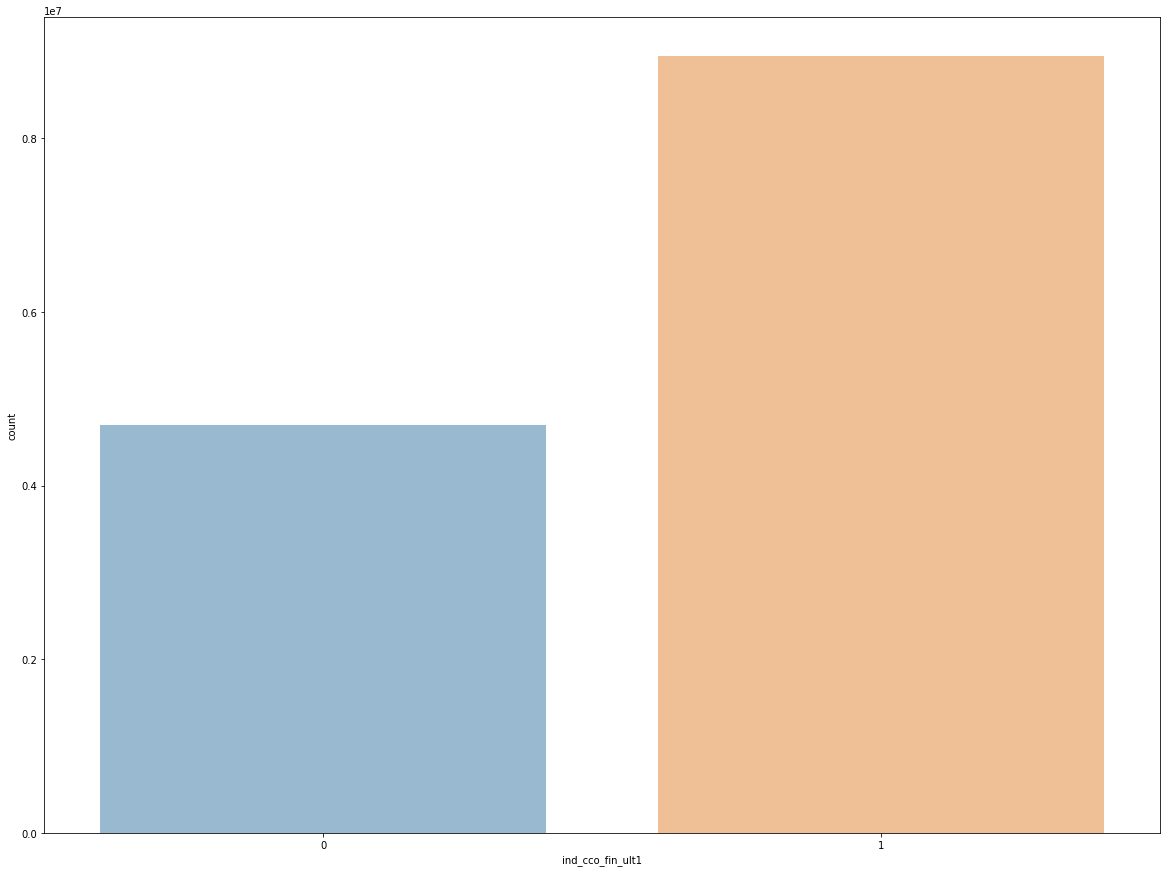

--------------------------------------------------
col :  ind_cder_fin_ult1


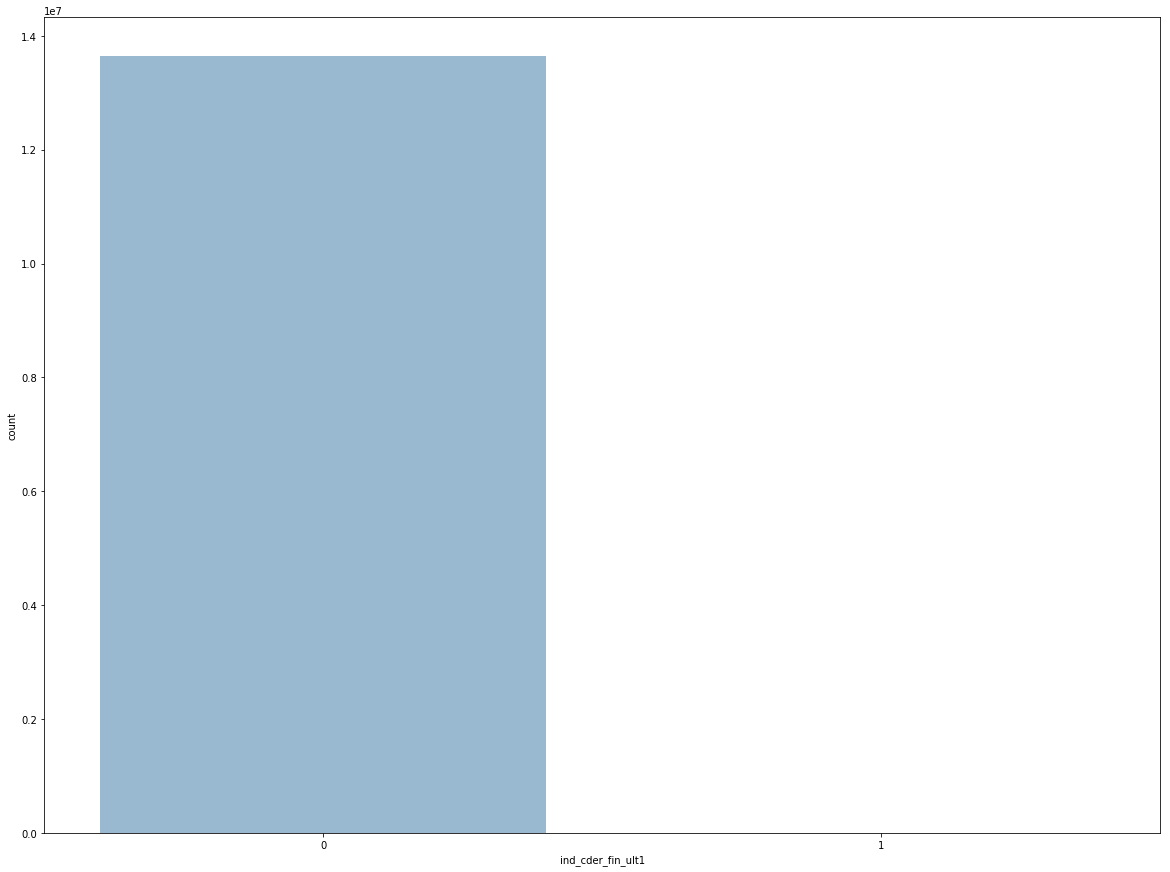

--------------------------------------------------
col :  ind_cno_fin_ult1


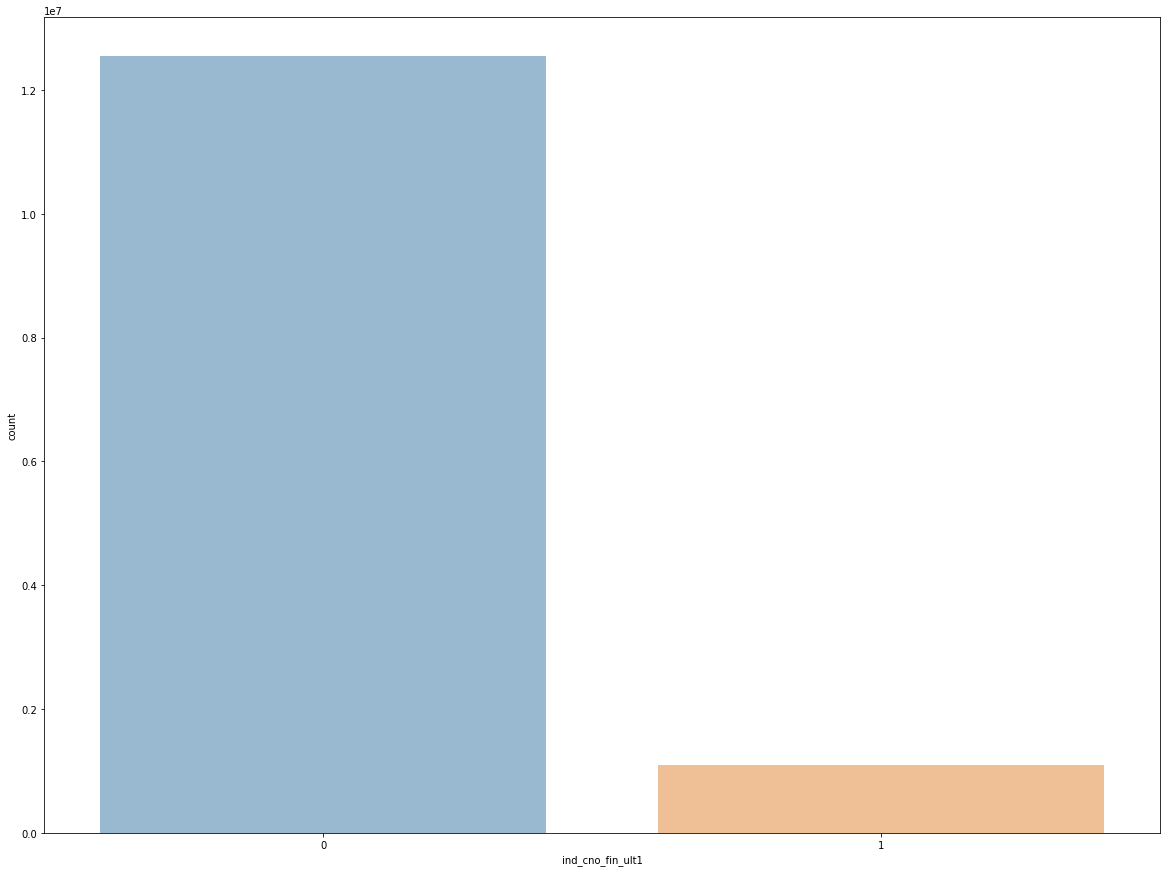

--------------------------------------------------
col :  ind_ctju_fin_ult1


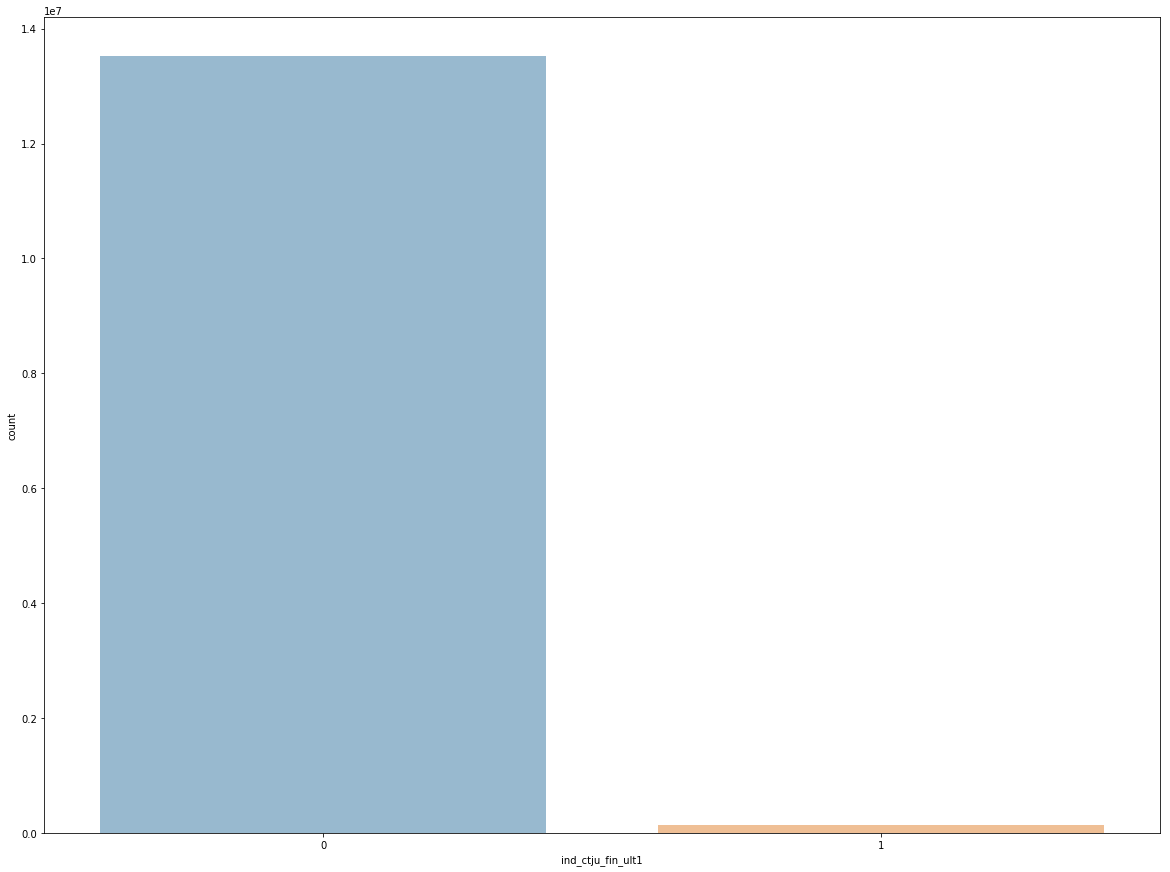

--------------------------------------------------
col :  ind_ctma_fin_ult1


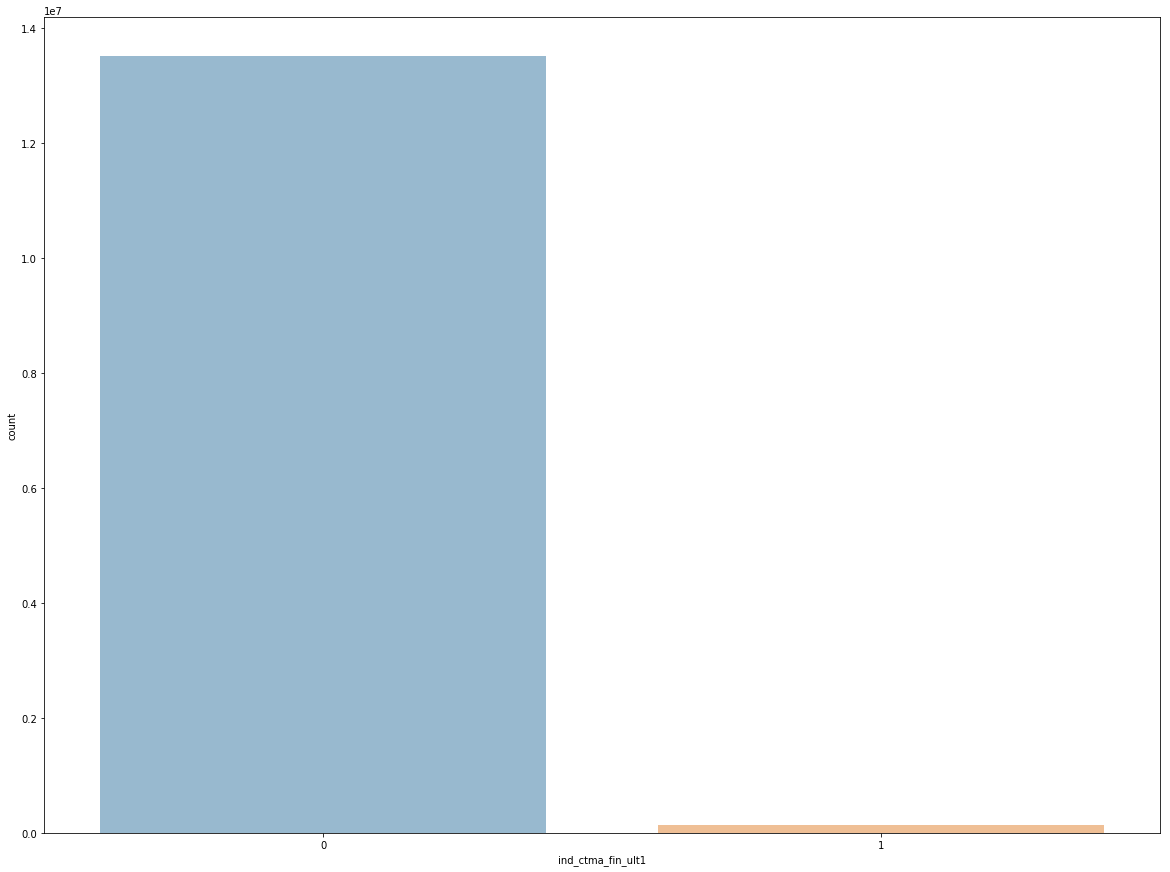

--------------------------------------------------
col :  ind_ctop_fin_ult1


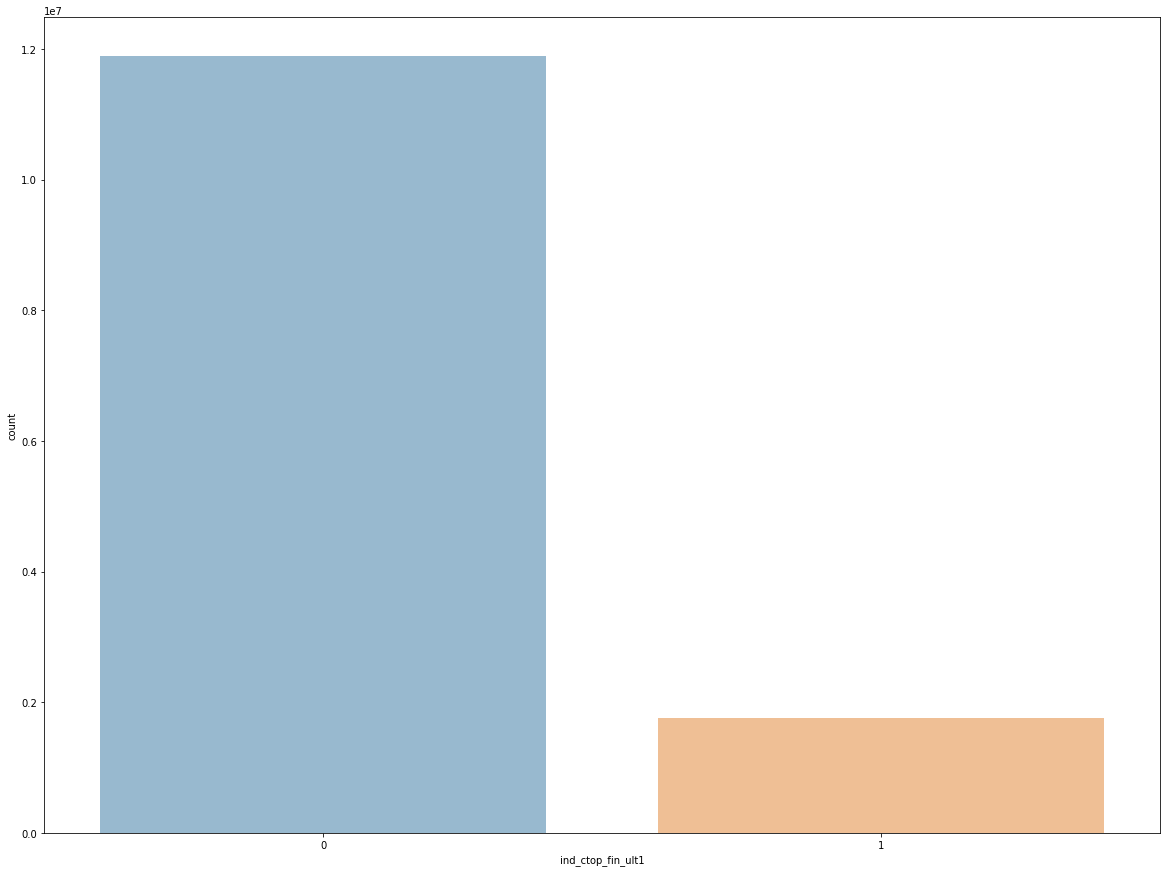

--------------------------------------------------
col :  ind_ctpp_fin_ult1


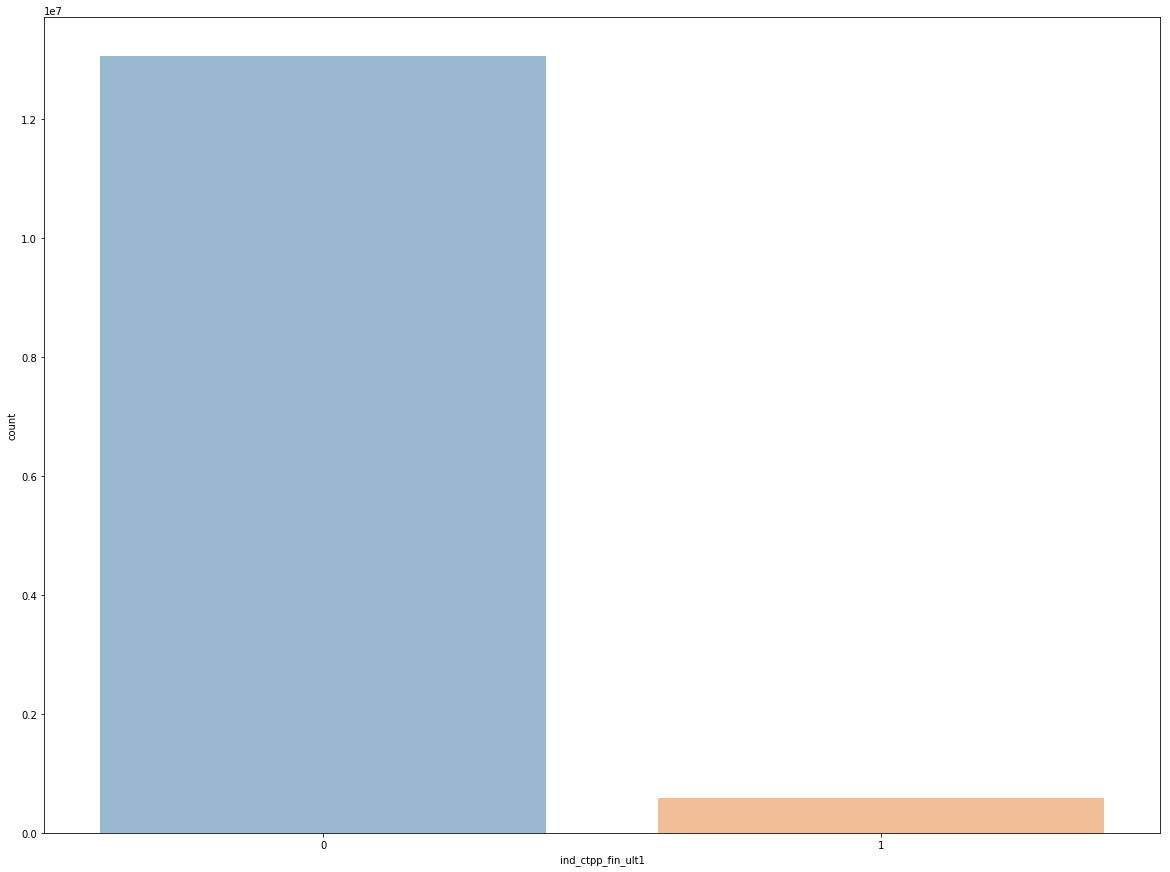

--------------------------------------------------
col :  ind_deco_fin_ult1


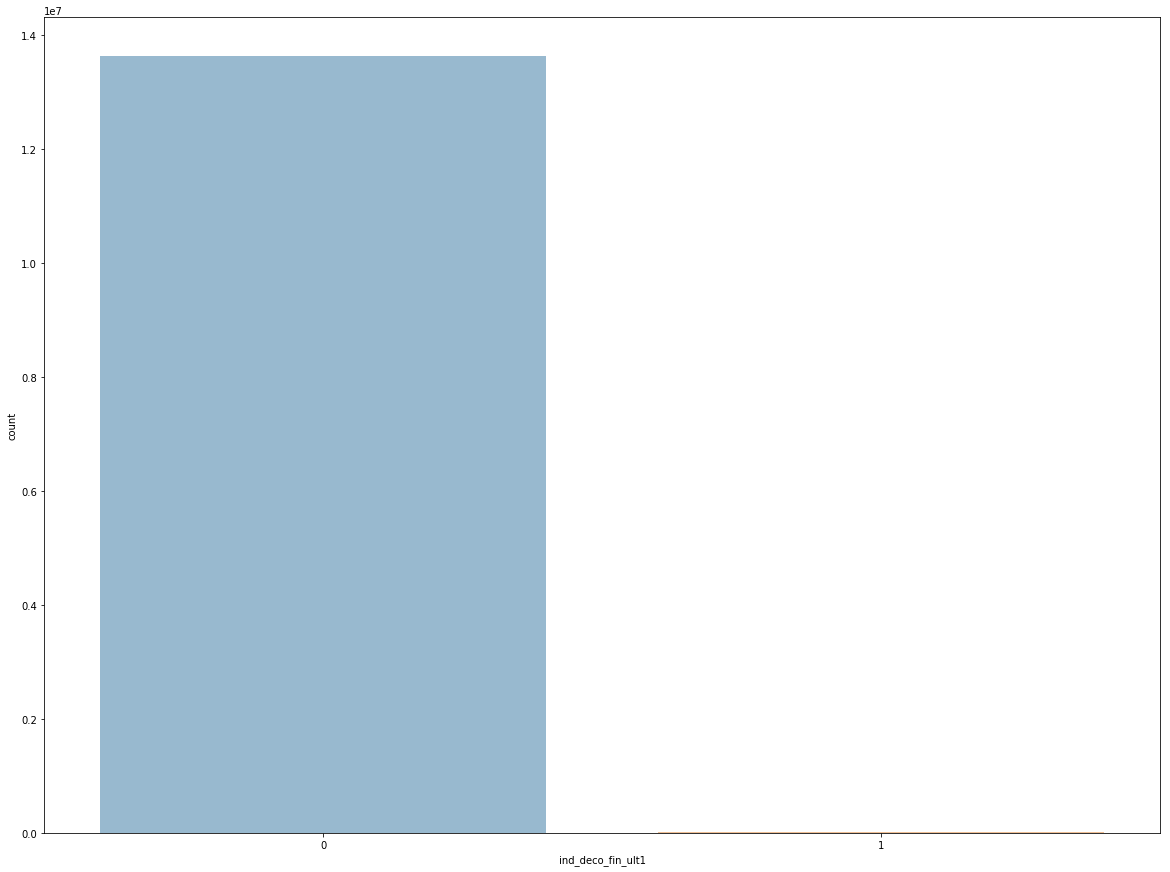

--------------------------------------------------
col :  ind_deme_fin_ult1


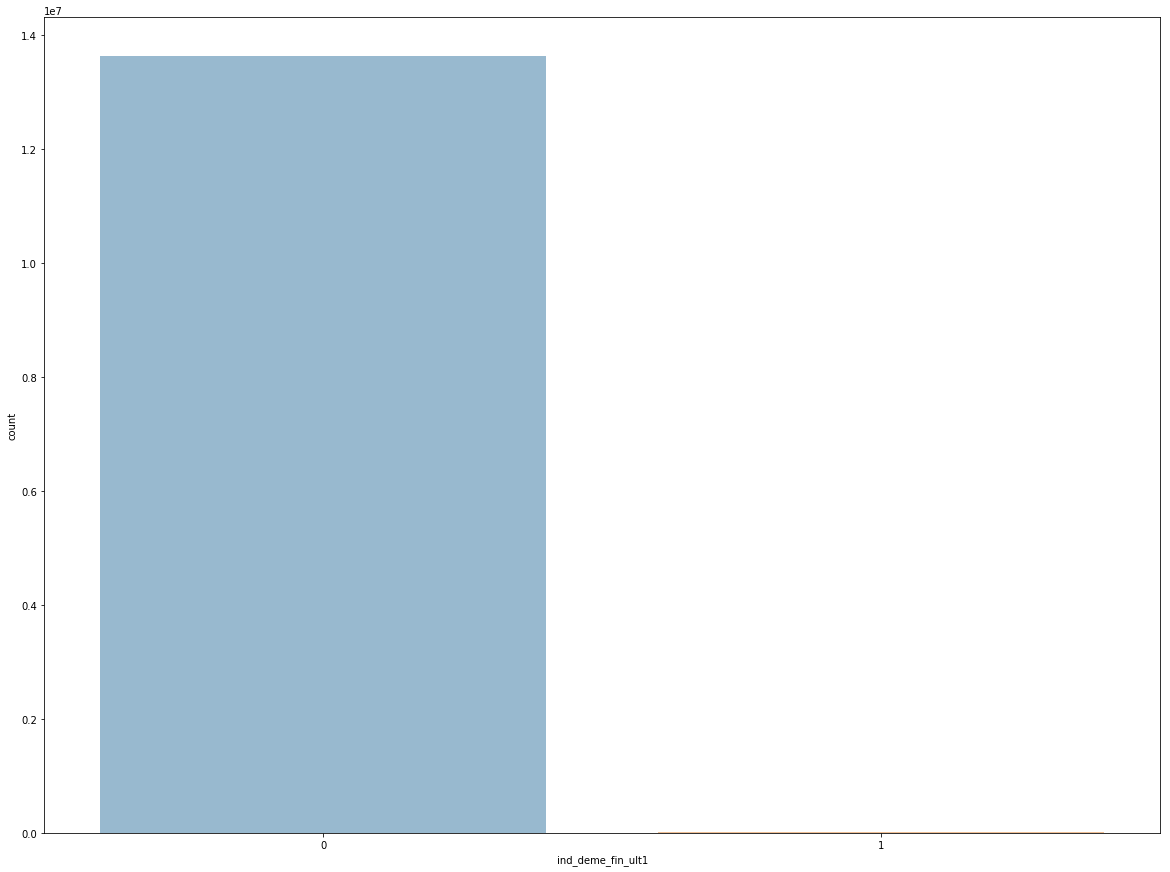

--------------------------------------------------
col :  ind_dela_fin_ult1


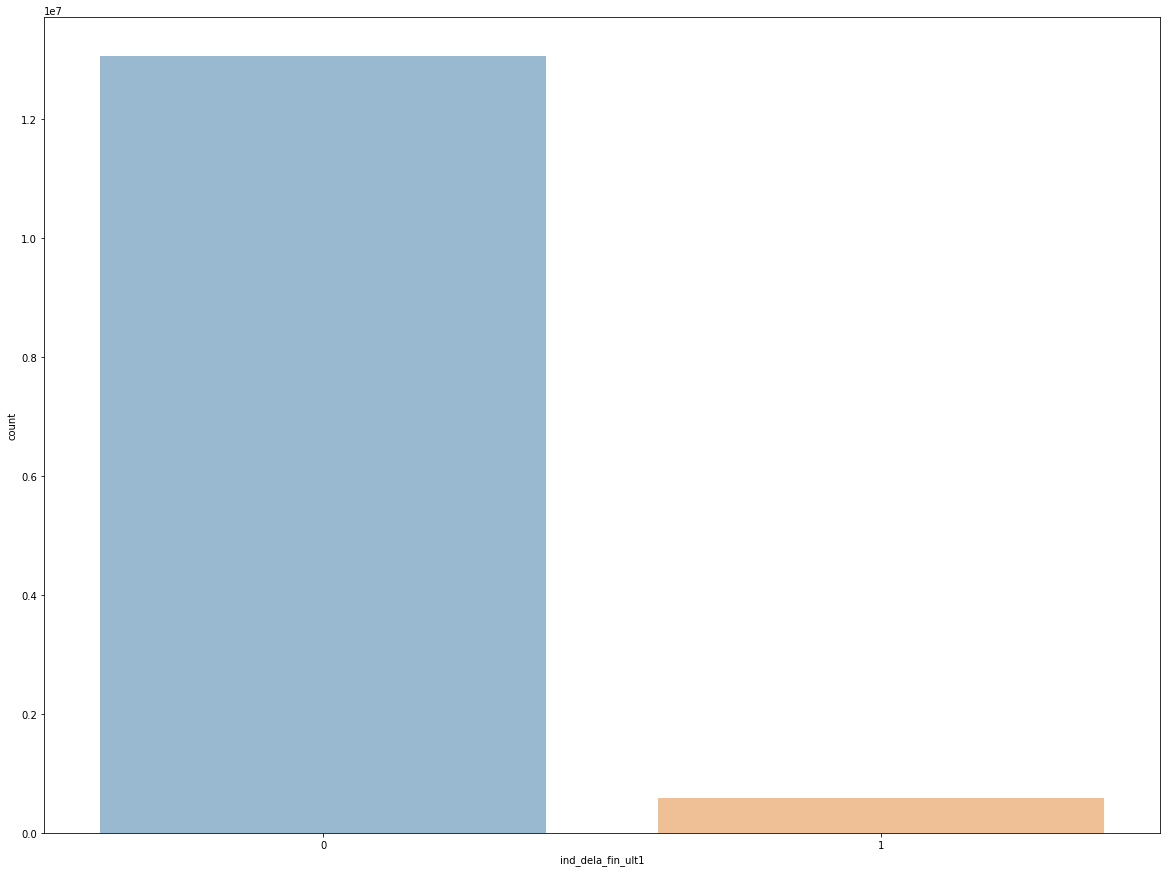

--------------------------------------------------
col :  ind_ecue_fin_ult1


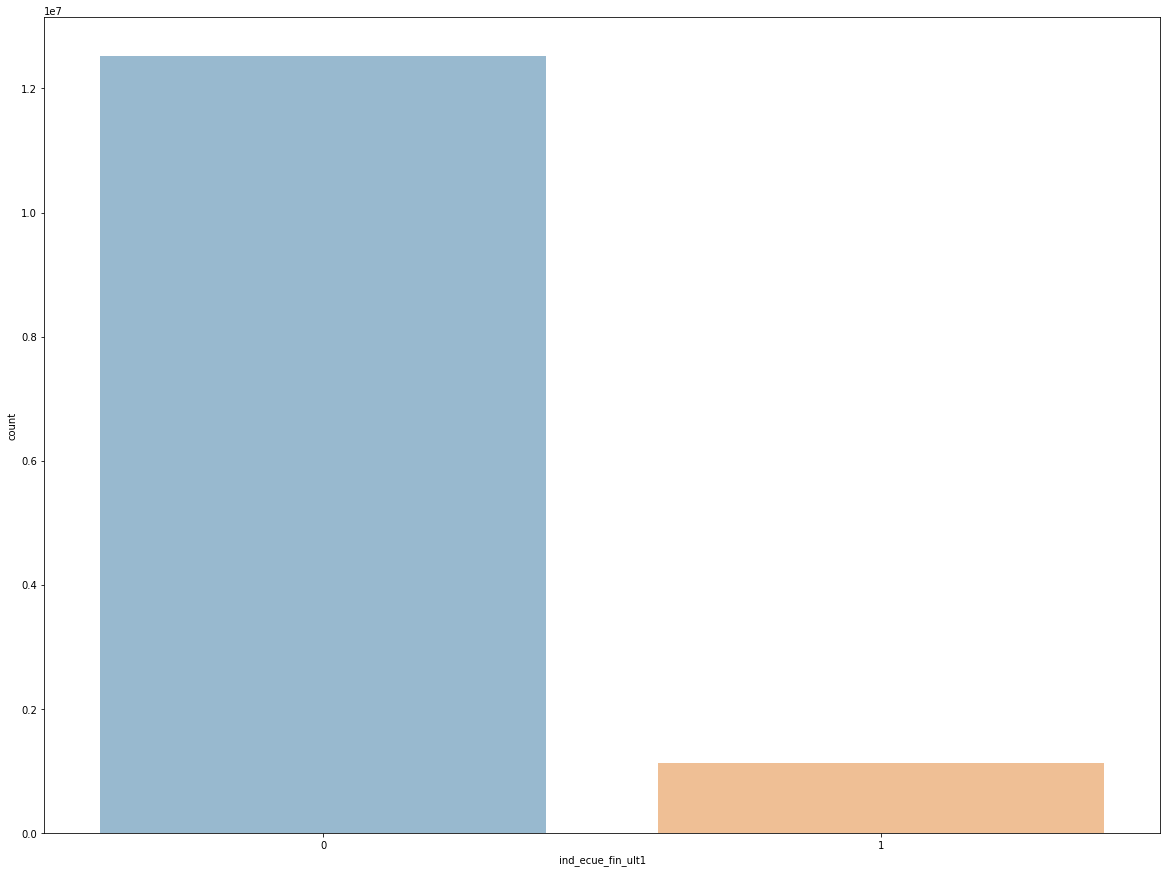

--------------------------------------------------
col :  ind_fond_fin_ult1


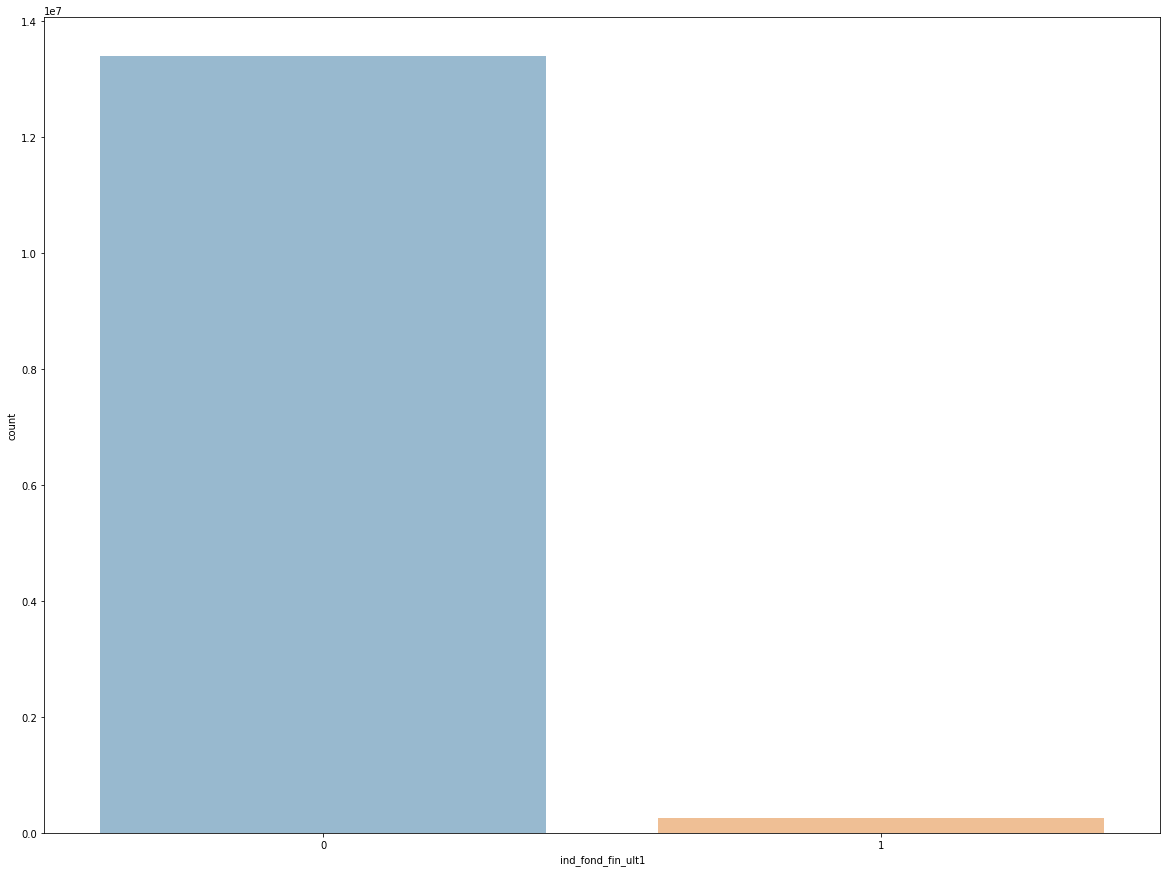

--------------------------------------------------
col :  ind_hip_fin_ult1


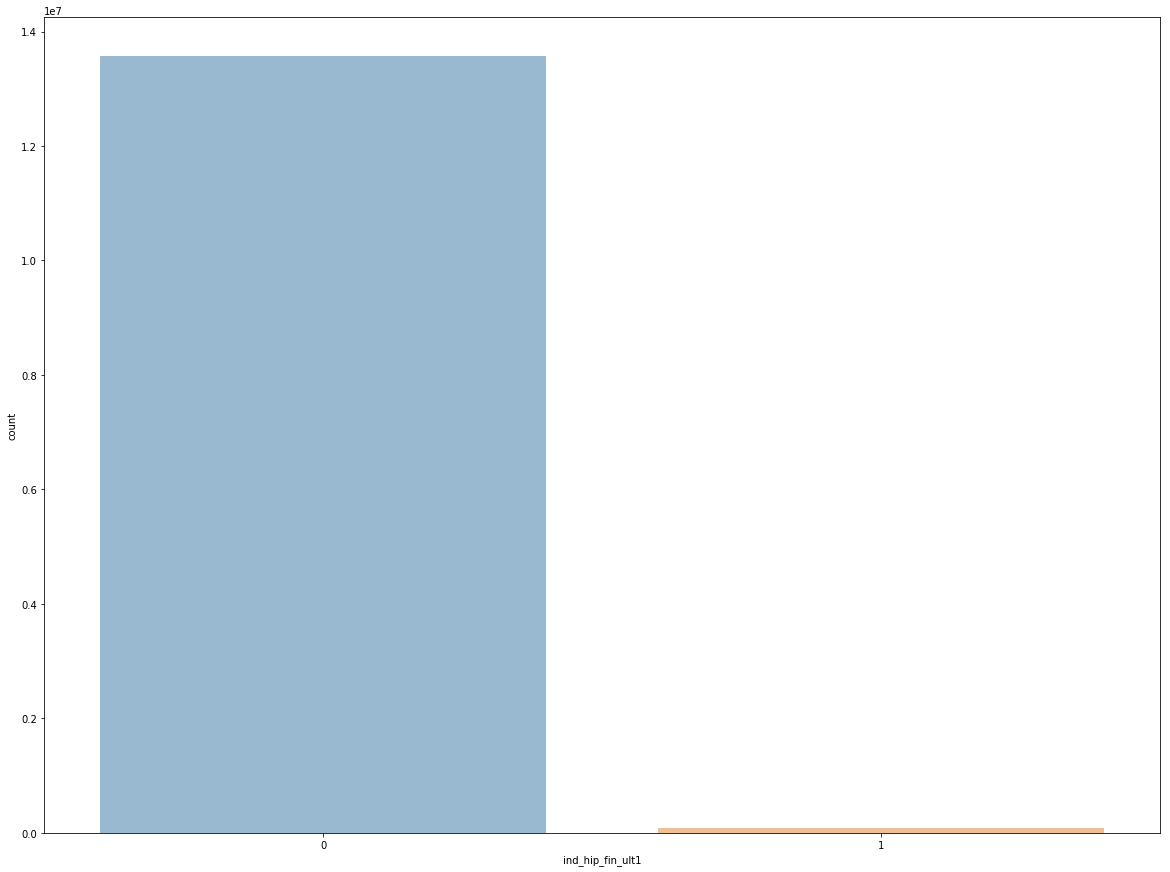

--------------------------------------------------
col :  ind_plan_fin_ult1


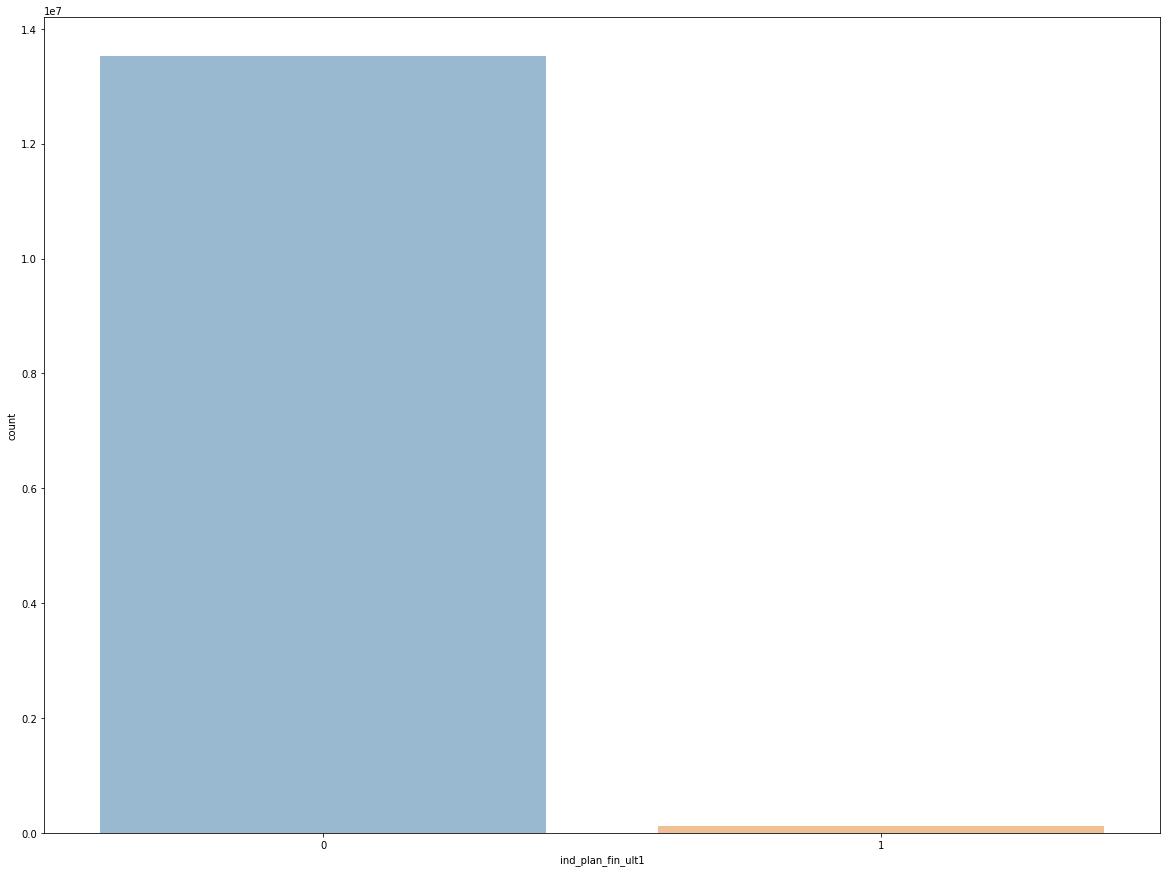

--------------------------------------------------
col :  ind_pres_fin_ult1


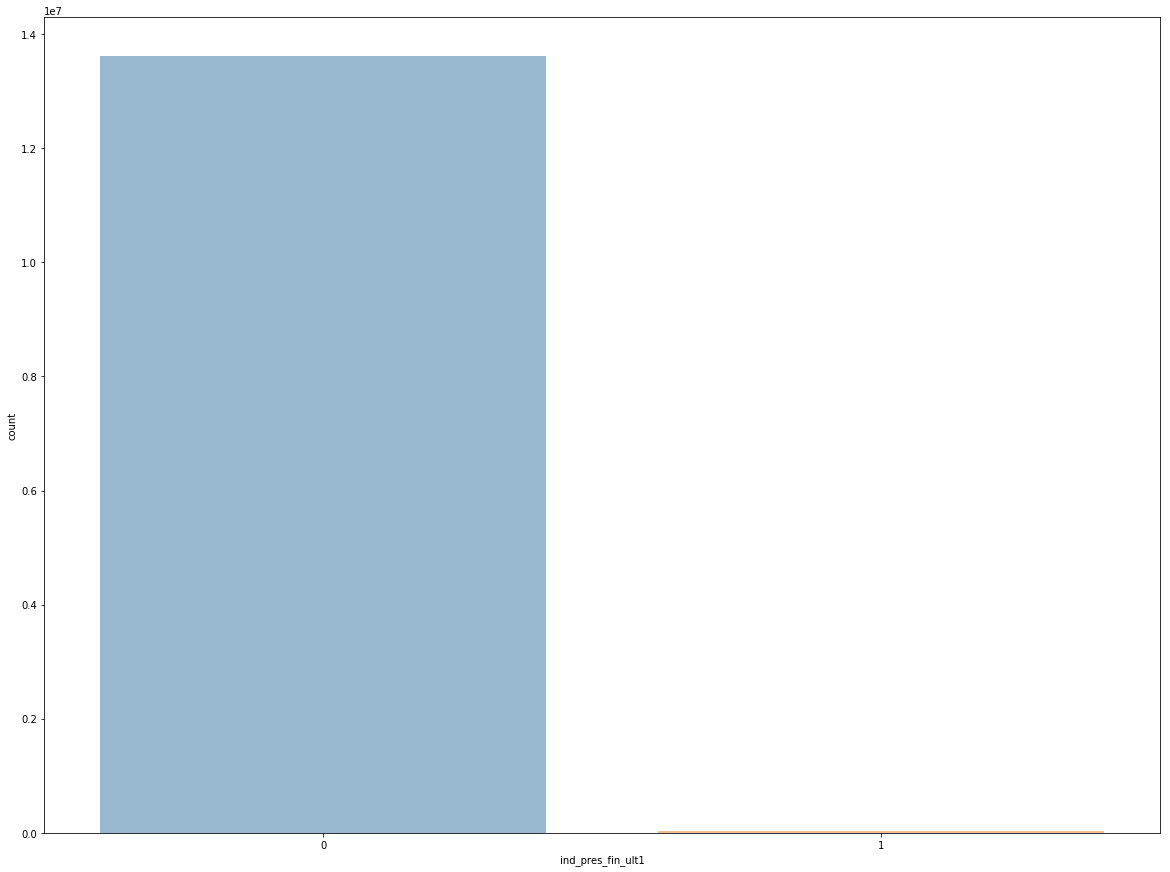

--------------------------------------------------
col :  ind_reca_fin_ult1


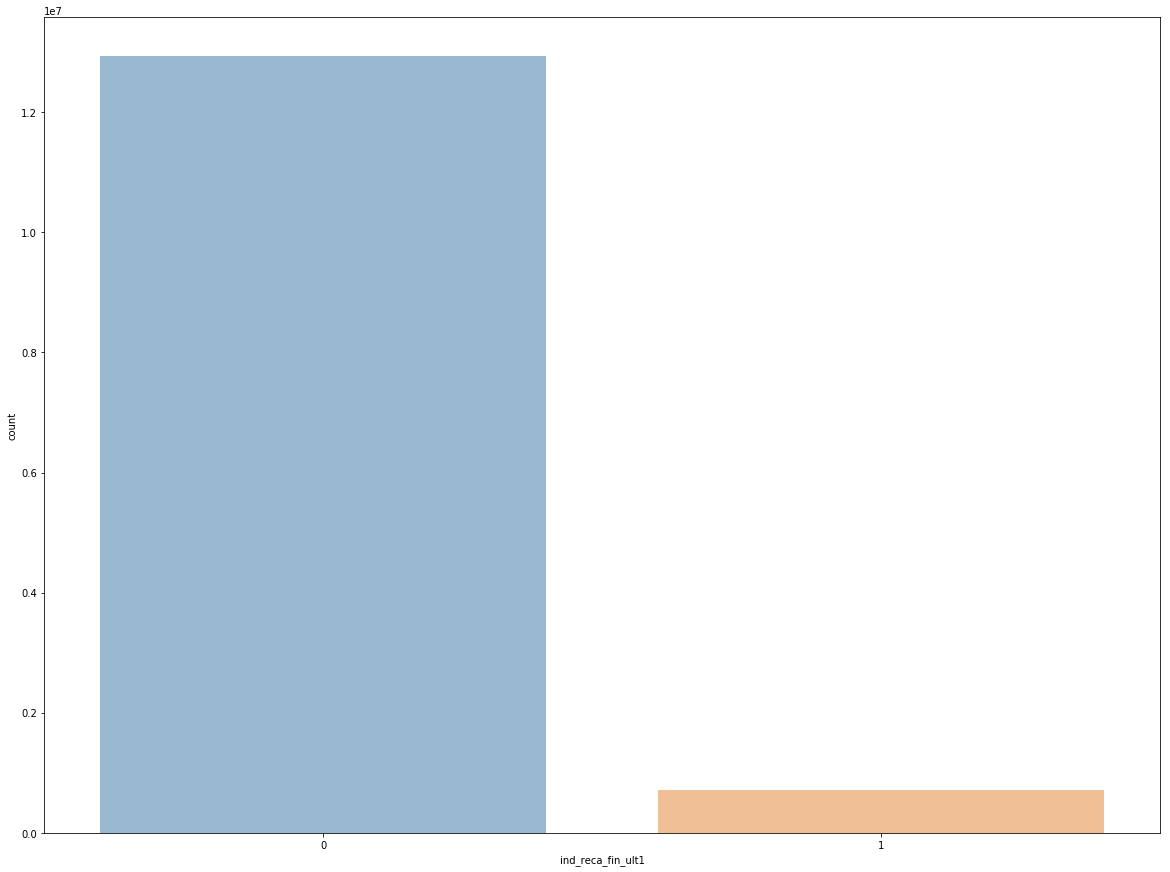

--------------------------------------------------
col :  ind_tjcr_fin_ult1


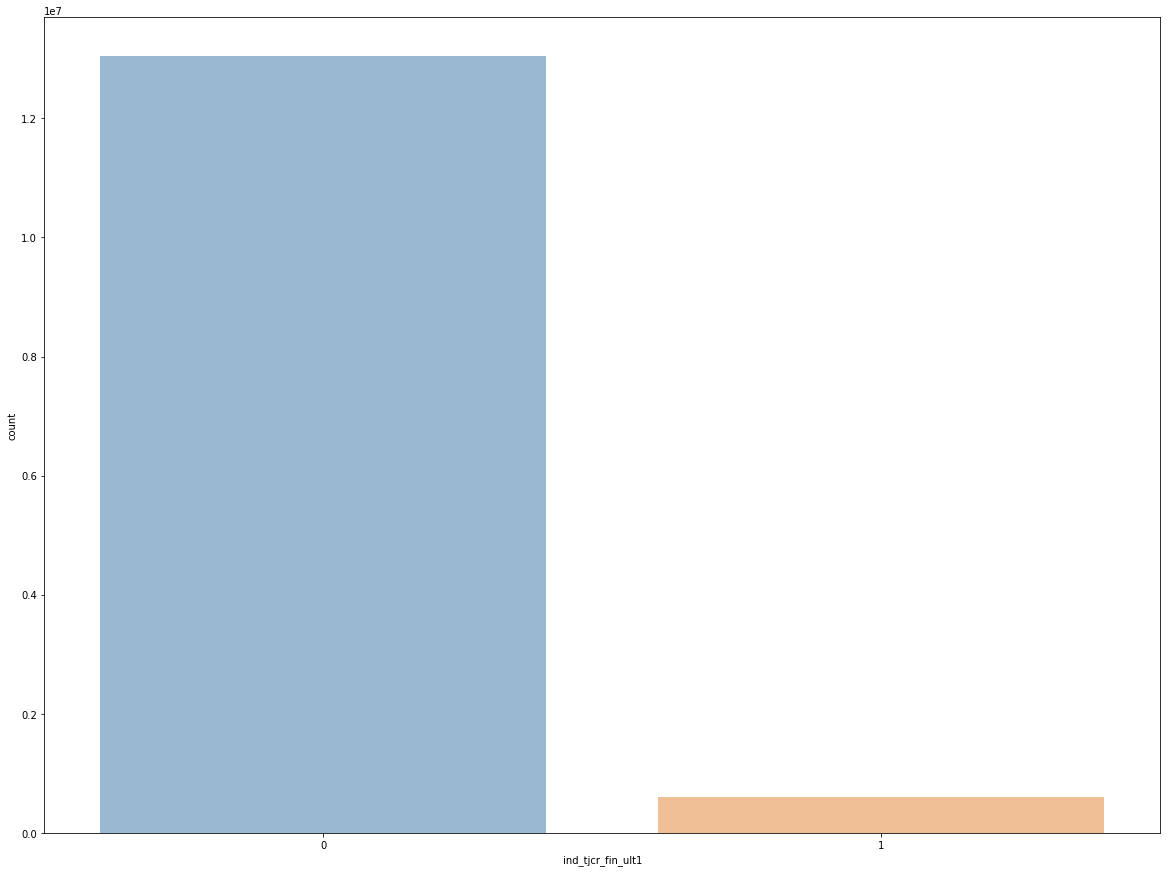

--------------------------------------------------
col :  ind_valo_fin_ult1


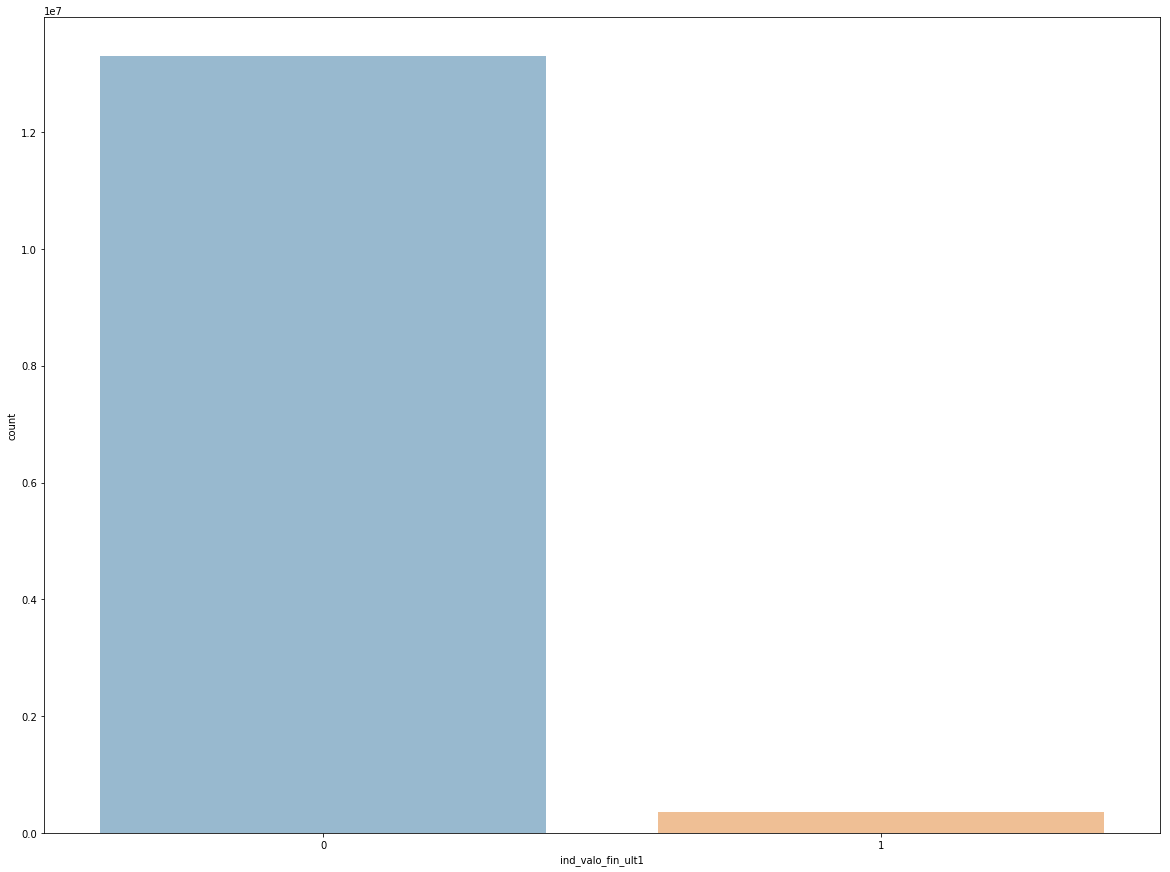

--------------------------------------------------
col :  ind_viv_fin_ult1


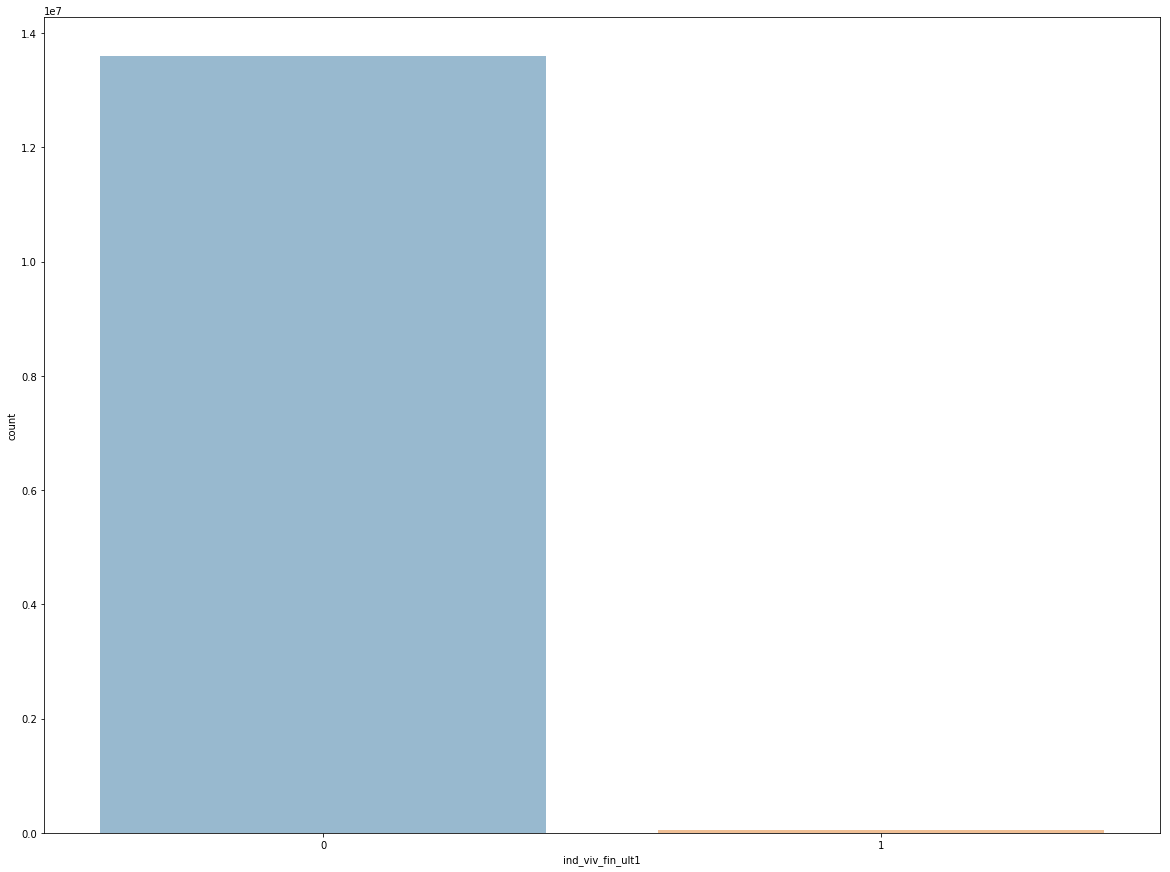

--------------------------------------------------
col :  ind_nomina_ult1


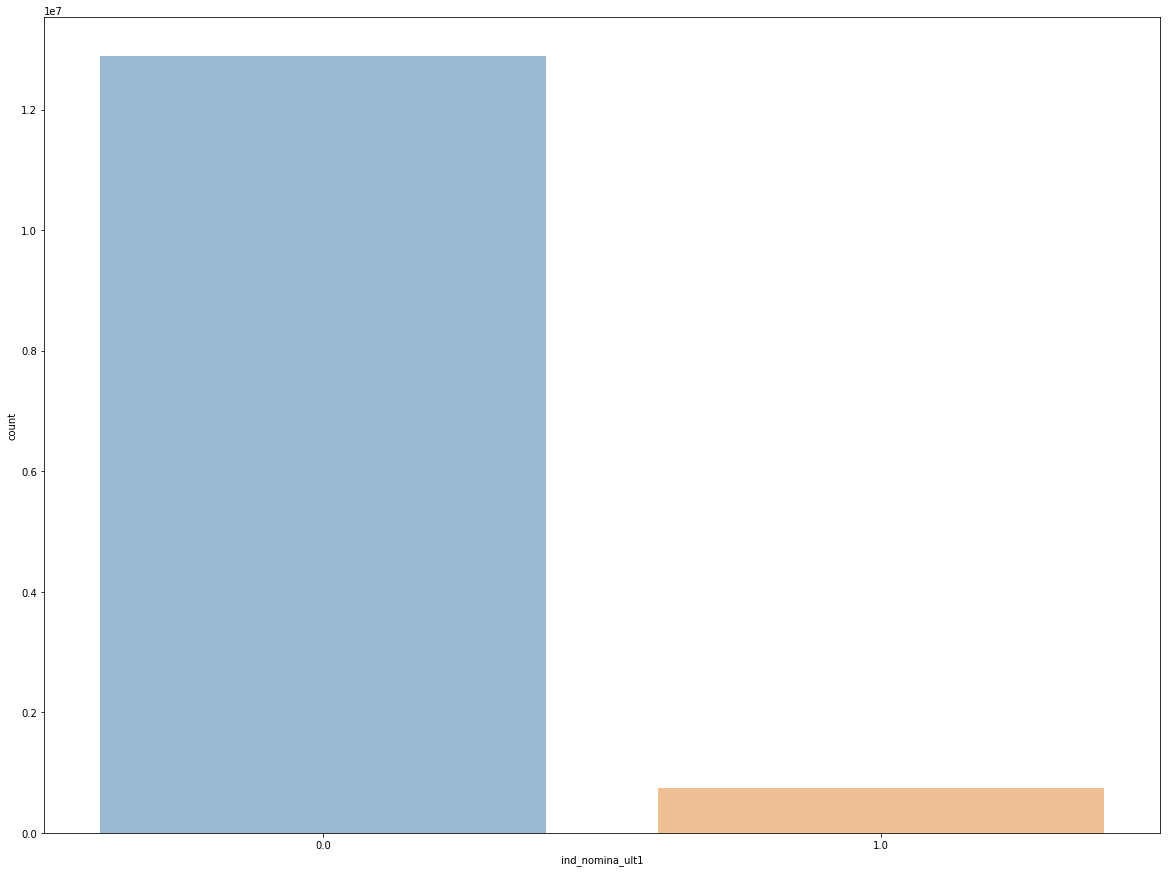

--------------------------------------------------
col :  ind_nom_pens_ult1


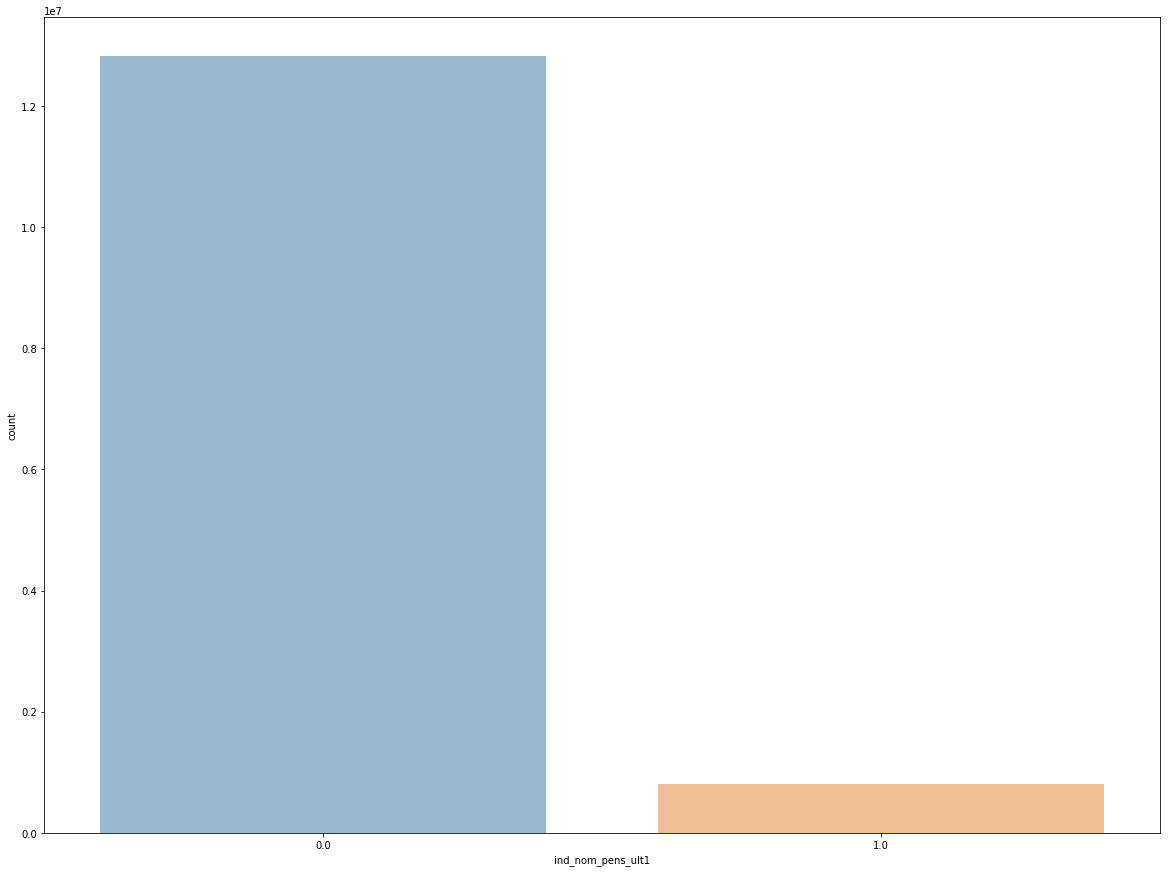

--------------------------------------------------
col :  ind_recibo_ult1


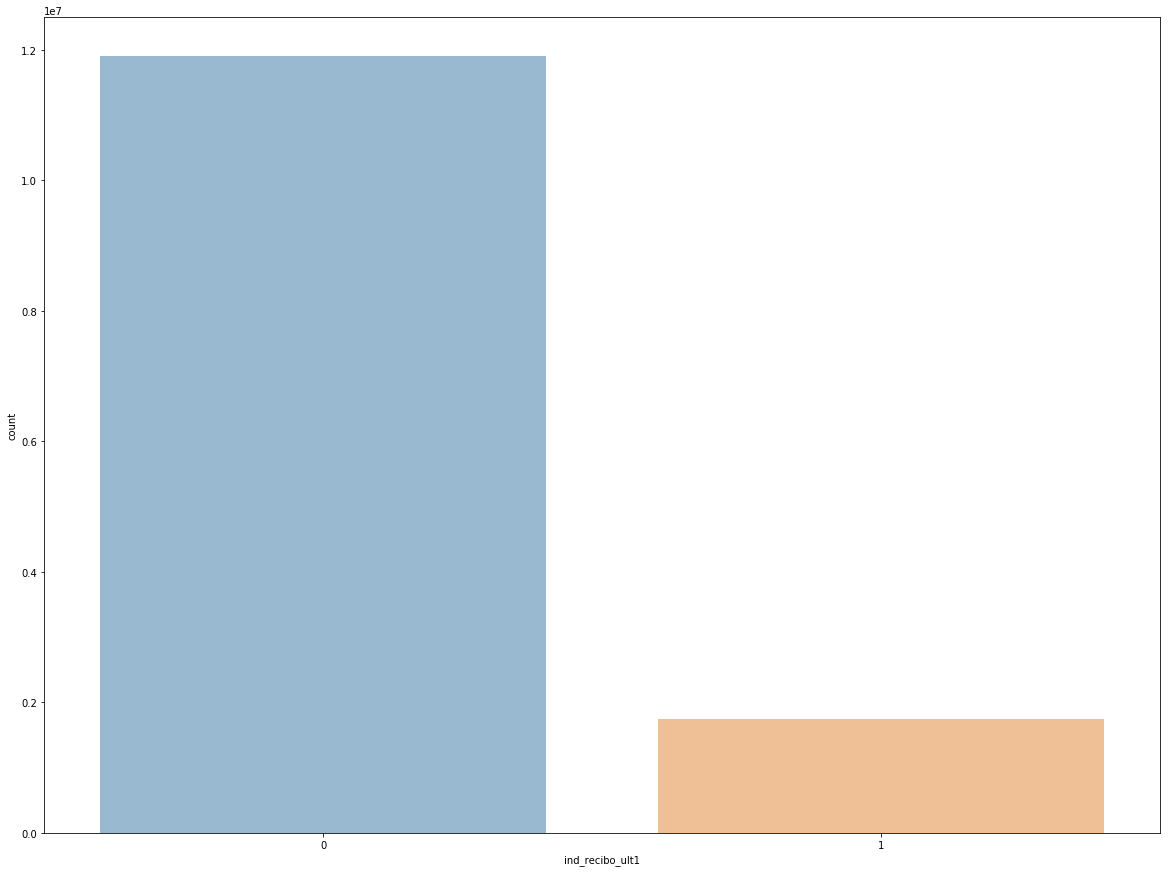

In [14]:
skip_cols = ['ncodpers', 'renta']
for col in trn.columns:
    if col in skip_cols:
        continue
        
    print('-' * 50)
    print('col : ', col)
    
    f, ax = plt.subplots(figsize=(20, 15))
    sns.countplot(x=col, data=trn, alpha=0.5)
    plt.show()